In [1]:
%matplotlib nbagg
#%load_ext line_profiler
#%load_ext memory_profiler

import jungfrau_utils as ju
import numpy as np
import json
import os, math
import time
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

import warnings
warnings.filterwarnings('ignore')

In [2]:
savedir = '/das/work/p19/p19262/Claudio/Reduced_data/'
os.makedirs(savedir, exist_ok=True)
print (savedir)

/das/work/p19/p19262/Claudio/Reduced_data/


## First load a few images to identify ROIs and check threshold

In [80]:
# data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet_timescan_loop_short2_1/run_010195*')
# nframes = 2000
data = SFDataFiles('/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_3004p2_10ps/run_008081.JF02T09V02.h5')
nframes = 1000
threshold_low = 2

##################################################################
clock = Clock()
total = 0
total_thr = 0
ch_JF = data['JF02T09V02']
images = ch_JF.data[:nframes]

print ('Loaded {} images'.format(images.shape[0]))

for i in range(nframes):
    single_image = images[i, :]
    image_thr = single_image.copy()
    image_thr[single_image < threshold_low] = 0
    total_thr += image_thr
    total += single_image
    #total /= nframes

print ("It took", clock.tick(), "seconds to process this file")

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_007970.JF02T09V02.res.h5
jungfrau file: 14:38 02.12.2021
pedestal file: 10:31 02.12.2021
    mtime difference: 4:07:48.284893
Loaded 1000 images
It took 42.74 seconds to process this file


<IPython.core.display.Javascript object>


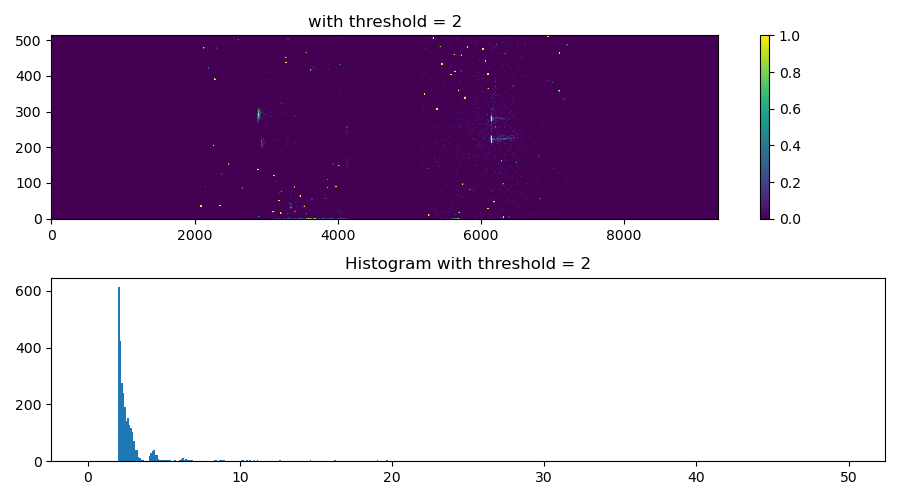

In [81]:
plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(211)
plt.imshow(total_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()
# plt.subplot(212)
# plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=3)
# plt.title("without threshold")
# plt.colorbar()
# plt.subplot(224)
# plt.title("Histogram without threshold")
# plt.hist(total.ravel(), bins=np.arange(0.1,50,0.1))
plt.subplot(212)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_thr.ravel(), bins=np.arange(0.1,50,0.1))
plt.tight_layout()
plt.show()

In [65]:
def process_image(image2D, threshold_low, threshold_high):
    image2D_thr = image2D.copy()
    #image2D_thr = convert_to_photon_num_range(image2D_thr, [threshold_low,threshold_high])
    image2D_thr[image2D < threshold_low] = 0
    image2D_thr[image2D > threshold_high] = 0
    image2D_thr = convert_to_photon_num_range(image2D_thr, [threshold_low,threshold_high])
    return image2D_thr

def plot_tool(spectra_ON, spectra_OFF, roi, bin_):
    x_axis = np.arange(roi[0], roi[1])
    spectra_on_rebin  = bin_sum(spectra_ON,  bin_)
    spectra_off_rebin = bin_sum(spectra_OFF, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    return x_axis_rebin, spectra_on_rebin, spectra_off_rebin
    

## Next cells for a single file, ONLY JF file!

In [56]:
DIR = '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_3004p2_10ps/'
run = 'run_008081'

In [82]:
roi1 = (2800, 3200, 180, 240) #signal CRY2 low
roi2 = (2800, 3200, 260, 320) #signal CRY2 up

roi3 = (6000, 6200, 200, 240) #signal CRY1 low
roi4 = (6000, 6200, 260, 320) #signal CRY1 up

threshold_low = 2
threshold_high = 10

######################################################################################
clock = Clock()
JF_single_file = DIR + run + '.JF02T09V02.h5'

spectrum_ON_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_ON_roi3 = 0
spectrum_ON_roi4 = 0
spectrum_OFF_roi1 = 0
spectrum_OFF_roi2 = 0
spectrum_OFF_roi3 = 0
spectrum_OFF_roi4 = 0

print("Processing file %s" % (JF_single_file))
clear_output(wait=True)
nshots = None

images_pump_roi1, images_pump_roi2, images_pump_roi3, images_pump_roi4, pids_ON, \
images_unpump_roi1, images_unpump_roi2, images_unpump_roi3, images_unpump_roi4, pids_OFF = \
    load_crop_JF_batches_on_off_4rois(JF_single_file, roi1, roi2, roi3, roi4, 100, 50, nshots=nshots)

images_pump_roi1_thr = process_image(images_pump_roi1, threshold_low, threshold_high)
images_unpump_roi1_thr = process_image(images_unpump_roi1, threshold_low, threshold_high)

images_pump_roi2_thr = process_image(images_pump_roi2, threshold_low, threshold_high)
images_unpump_roi2_thr = process_image(images_unpump_roi2, threshold_low, threshold_high)

images_pump_roi3_thr = process_image(images_pump_roi3, threshold_low, threshold_high)
images_unpump_roi3_thr = process_image(images_unpump_roi3, threshold_low, threshold_high)

images_pump_roi4_thr = process_image(images_pump_roi4, threshold_low, threshold_high)
images_unpump_roi4_thr = process_image(images_unpump_roi4, threshold_low, threshold_high)

spectrum_ON_roi1 += images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)# - images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_ON_roi2 += images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_ON_roi3 += images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)# - images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
spectrum_ON_roi4 += images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)

spectrum_OFF_roi1 += images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)# - images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_OFF_roi2 += images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
spectrum_OFF_roi3 += images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)# - images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
spectrum_OFF_roi4 += images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)

print ("It took", clock.tick(), "seconds to process this file")

#print ("It took", clock.tock(), "seconds to process {} files".format(len(patch)))

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_007970.JF02T09V02.res.h5
jungfrau file: 14:38 02.12.2021
pedestal file: 10:31 02.12.2021
    mtime difference: 4:07:48.284893
Total images = 5001, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 3000, None)
Load batch = slice(3000, 4000, None)
Load batch = slice(4000, 5000, None)
Load batch = slice(5000, 5001, None)
It took 14.04 seconds to process this file


<IPython.core.display.Javascript object>


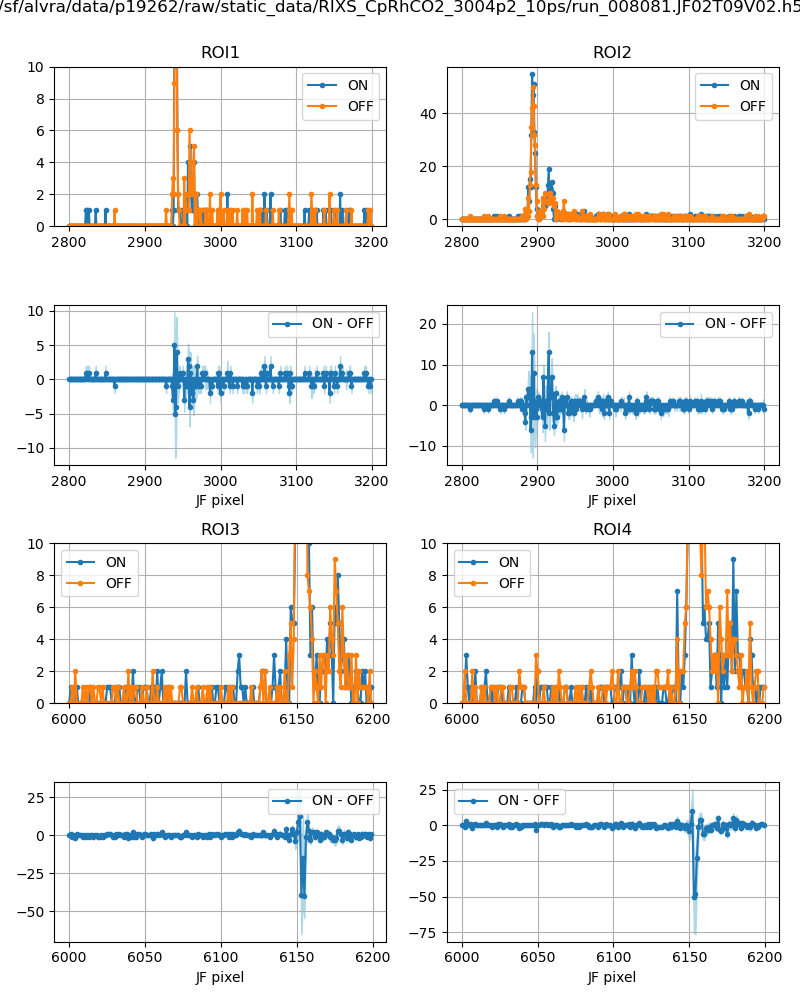

In [83]:
from textwrap import wrap
bin1_ = 1  # change the bin size if wanted, 1 is every pixel
bin2_ = 1
bin3_ = 1  # change the bin size if wanted, 1 is every pixel
bin4_ = 1 

x_axis_rebin1, spectra_on_rebin1, spectra_off_rebin1 = plot_tool(spectrum_ON_roi1, spectrum_OFF_roi1, roi1, bin1_)
x_axis_rebin2, spectra_on_rebin2, spectra_off_rebin2 = plot_tool(spectrum_ON_roi2, spectrum_OFF_roi2, roi2, bin2_)
x_axis_rebin3, spectra_on_rebin3, spectra_off_rebin3 = plot_tool(spectrum_ON_roi3, spectrum_OFF_roi3, roi3, bin3_)
x_axis_rebin4, spectra_on_rebin4, spectra_off_rebin4 = plot_tool(spectrum_ON_roi4, spectrum_OFF_roi4, roi4, bin4_)

spectra_on_err1  = np.sqrt(abs(spectra_on_rebin1))
spectra_off_err1 = np.sqrt(abs(spectra_off_rebin1))
spectra_on_err2  = np.sqrt(abs(spectra_on_rebin2))
spectra_off_err2 = np.sqrt(abs(spectra_off_rebin2))
spectra_on_err3  = np.sqrt(abs(spectra_on_rebin3))
spectra_off_err3 = np.sqrt(abs(spectra_off_rebin3))
spectra_on_err4  = np.sqrt(abs(spectra_on_rebin4))
spectra_off_err4 = np.sqrt(abs(spectra_off_rebin4))

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
low_err2= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err2= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
low_err3= (spectra_on_rebin3 - spectra_off_rebin3)-np.sqrt(spectra_on_err3**2+spectra_off_err3**2)
high_err3= (spectra_on_rebin3 - spectra_off_rebin3)+np.sqrt(spectra_on_err3**2+spectra_off_err3**2)
low_err4= (spectra_on_rebin4 - spectra_off_rebin4)-np.sqrt(spectra_on_err4**2+spectra_off_err4**2)
high_err4= (spectra_on_rebin4 - spectra_off_rebin4)+np.sqrt(spectra_on_err4**2+spectra_off_err4**2)

plt.figure(figsize=(8,10))
plt.suptitle(JF_single_file, y = 1)

plt.subplot(421)
plt.title('ROI1')
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.ylim(0,10)
plt.legend(loc="best")
plt.grid()

plt.subplot(422)
plt.title('ROI2')
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(425)
plt.title('ROI3')
plt.plot(x_axis_rebin3, spectra_on_rebin3, label="ON", marker='.')
plt.plot(x_axis_rebin3, spectra_off_rebin3, label="OFF", marker='.')
plt.ylim(0,10)
plt.legend(loc="best")
plt.grid()

plt.subplot(426)
plt.title('ROI4')
plt.plot(x_axis_rebin4, spectra_on_rebin4, label="ON", marker='.')
plt.plot(x_axis_rebin4, spectra_off_rebin4, label="OFF", marker='.')
plt.ylim(0,10)
plt.legend(loc="best")
plt.grid()

plt.subplot(423)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(424)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin2, low_err2, high_err2, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(427)
plt.plot(x_axis_rebin3,spectra_on_rebin3 - spectra_off_rebin3, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin3, low_err3, high_err3, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(428)
plt.plot(x_axis_rebin4,spectra_on_rebin4 - spectra_off_rebin4, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin4, low_err4, high_err4, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.tight_layout()
plt.show()

## Next cells to sum up individual runs, ONLY JF file!

In [103]:
datalist = []
for file in glob.glob('/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/*JF*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist[0:]
print (len(patch))
patch

79


['/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008545.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008546.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008547.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008548.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008549.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008550.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008551.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008552.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008553.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008554.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_50fs_3001eV/run_008555.JF02

In [93]:
roi1 = (2800, 3200, 180, 240) #signal CRY2 low
roi2 = (2800, 3200, 260, 320) #signal CRY2 up

roi3 = (6000, 6200, 200, 240) #signal CRY1 low
roi4 = (6000, 6200, 260, 320) #signal CRY1 up

threshold_low = 2
threshold_high = 10

######################################################################################
clock = Clock()

spectrum_ON_roi1_all = []
spectrum_ON_roi2_all = []
spectrum_ON_roi3_all = []
spectrum_ON_roi4_all = []

spectrum_OFF_roi1_all = []
spectrum_OFF_roi2_all = []
spectrum_OFF_roi3_all = []
spectrum_OFF_roi4_all = []
i = 0

for JF_single_file in patch:
    print (JF_single_file)

    spectrum_ON_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_ON_roi3 = 0
    spectrum_ON_roi4 = 0
    spectrum_OFF_roi1 = 0
    spectrum_OFF_roi2 = 0
    spectrum_OFF_roi3 = 0
    spectrum_OFF_roi4 = 0
    
    
    print("File {} out of {}: Processing {}".format(i+1, len(patch), JF_single_file.split('/')[-1]))
    
    nshots = None

    images_pump_roi1, images_pump_roi2, images_pump_roi3, images_pump_roi4, pids_ON, \
    images_unpump_roi1, images_unpump_roi2, images_unpump_roi3, images_unpump_roi4, pids_OFF = \
        load_crop_JF_batches_on_off_4rois(JF_single_file, roi1, roi2, roi3, roi4, 100, 50, nshots=nshots)

    images_pump_roi1_thr = process_image(images_pump_roi1, threshold_low, threshold_high)
    images_unpump_roi1_thr = process_image(images_unpump_roi1, threshold_low, threshold_high)

    images_pump_roi2_thr = process_image(images_pump_roi2, threshold_low, threshold_high)
    images_unpump_roi2_thr = process_image(images_unpump_roi2, threshold_low, threshold_high)

    images_pump_roi3_thr = process_image(images_pump_roi3, threshold_low, threshold_high)
    images_unpump_roi3_thr = process_image(images_unpump_roi3, threshold_low, threshold_high)

    images_pump_roi4_thr = process_image(images_pump_roi4, threshold_low, threshold_high)
    images_unpump_roi4_thr = process_image(images_unpump_roi4, threshold_low, threshold_high)

    spectrum_ON_roi1 += images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)# - images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 += images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi3 += images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)# - images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi4 += images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)

    spectrum_OFF_roi1 += images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)# - images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 += images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi3 += images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)# - images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi4 += images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    spectrum_ON_roi1_all.append(spectrum_ON_roi1)
    spectrum_ON_roi2_all.append(spectrum_ON_roi2)
    spectrum_ON_roi3_all.append(spectrum_ON_roi3)
    spectrum_ON_roi4_all.append(spectrum_ON_roi4)
    spectrum_OFF_roi1_all.append(spectrum_OFF_roi1)
    spectrum_OFF_roi2_all.append(spectrum_OFF_roi2)
    spectrum_OFF_roi3_all.append(spectrum_OFF_roi3)
    spectrum_OFF_roi4_all.append(spectrum_OFF_roi4)
    i+=1
    print ("It took", clock.tick(), "seconds to process this file")
    clear_output(wait=True)
    
spectrum_ON_roi1_all = np.asarray(spectrum_ON_roi1_all)
spectrum_ON_roi2_all = np.asarray(spectrum_ON_roi2_all)
spectrum_ON_roi3_all = np.asarray(spectrum_ON_roi3_all)
spectrum_ON_roi4_all = np.asarray(spectrum_ON_roi4_all)
spectrum_OFF_roi1_all = np.asarray(spectrum_OFF_roi1_all)
spectrum_OFF_roi2_all = np.asarray(spectrum_OFF_roi2_all)
spectrum_OFF_roi3_all = np.asarray(spectrum_OFF_roi3_all)
spectrum_OFF_roi4_all = np.asarray(spectrum_OFF_roi4_all)


print ("It took", clock.tock(), "seconds to process this file")

It took 934.66 seconds to process this file


<IPython.core.display.Javascript object>


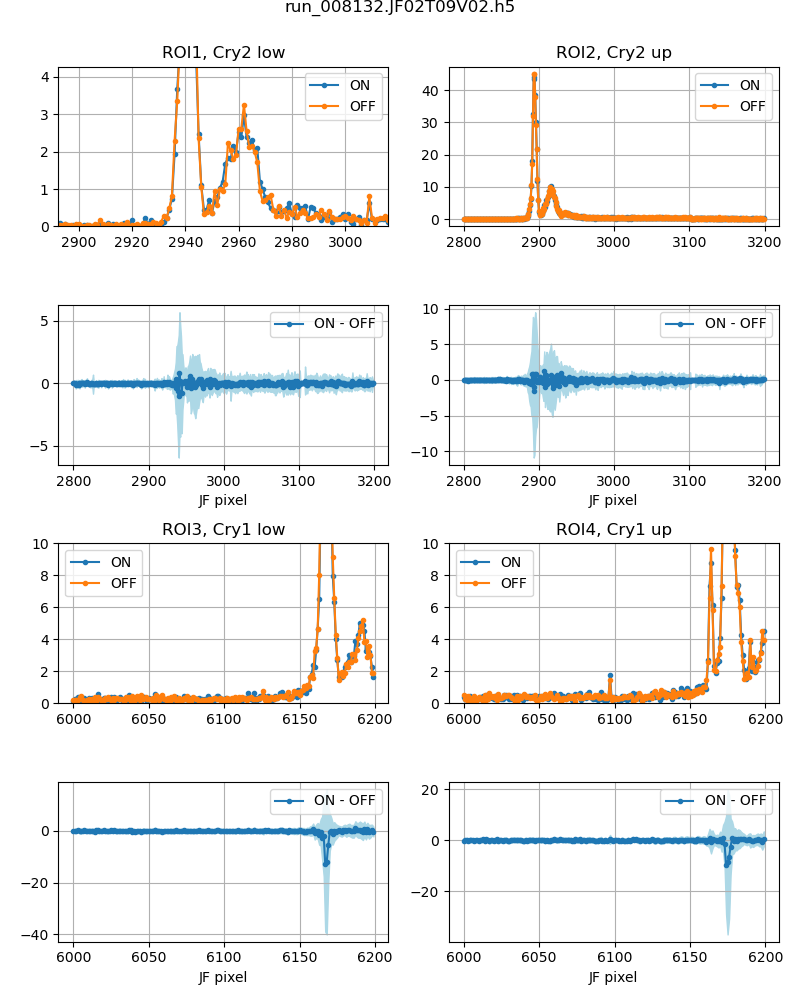

In [99]:
spectrum_ON_roi1 = np.mean(spectrum_ON_roi1_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_ON_roi2_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_ON_roi3_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_ON_roi4_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_OFF_roi1_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_OFF_roi2_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_OFF_roi3_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_OFF_roi4_all, axis = 0)


from textwrap import wrap
bin1_ = 1  # change the bin size if wanted, 1 is every pixel
bin2_ = 1
bin3_ = 1  # change the bin size if wanted, 1 is every pixel
bin4_ = 1 

x_axis_rebin1, spectra_on_rebin1, spectra_off_rebin1 = plot_tool(spectrum_ON_roi1, spectrum_OFF_roi1, roi1, bin1_)
x_axis_rebin2, spectra_on_rebin2, spectra_off_rebin2 = plot_tool(spectrum_ON_roi2, spectrum_OFF_roi2, roi2, bin2_)
x_axis_rebin3, spectra_on_rebin3, spectra_off_rebin3 = plot_tool(spectrum_ON_roi3, spectrum_OFF_roi3, roi3, bin3_)
x_axis_rebin4, spectra_on_rebin4, spectra_off_rebin4 = plot_tool(spectrum_ON_roi4, spectrum_OFF_roi4, roi4, bin4_)

spectra_on_err1  = np.sqrt(abs(spectra_on_rebin1))
spectra_off_err1 = np.sqrt(abs(spectra_off_rebin1))
spectra_on_err2  = np.sqrt(abs(spectra_on_rebin2))
spectra_off_err2 = np.sqrt(abs(spectra_off_rebin2))
spectra_on_err3  = np.sqrt(abs(spectra_on_rebin3))
spectra_off_err3 = np.sqrt(abs(spectra_off_rebin3))
spectra_on_err4  = np.sqrt(abs(spectra_on_rebin4))
spectra_off_err4 = np.sqrt(abs(spectra_off_rebin4))

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
low_err2= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err2= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
low_err3= (spectra_on_rebin3 - spectra_off_rebin3)-np.sqrt(spectra_on_err3**2+spectra_off_err3**2)
high_err3= (spectra_on_rebin3 - spectra_off_rebin3)+np.sqrt(spectra_on_err3**2+spectra_off_err3**2)
low_err4= (spectra_on_rebin4 - spectra_off_rebin4)-np.sqrt(spectra_on_err4**2+spectra_off_err4**2)
high_err4= (spectra_on_rebin4 - spectra_off_rebin4)+np.sqrt(spectra_on_err4**2+spectra_off_err4**2)

plt.figure(figsize=(8,10))
plt.suptitle(JF_single_file.split('/')[-1], y = 1)

plt.subplot(421)
plt.title('ROI1, Cry2 low')
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.ylim(0,10)
plt.legend(loc="best")
plt.grid()

plt.subplot(422)
plt.title('ROI2, Cry2 up')
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(425)
plt.title('ROI3, Cry1 low')
plt.plot(x_axis_rebin3, spectra_on_rebin3, label="ON", marker='.')
plt.plot(x_axis_rebin3, spectra_off_rebin3, label="OFF", marker='.')
plt.ylim(0,10)
plt.legend(loc="best")
plt.grid()

plt.subplot(426)
plt.title('ROI4, Cry1 up')
plt.plot(x_axis_rebin4, spectra_on_rebin4, label="ON", marker='.')
plt.plot(x_axis_rebin4, spectra_off_rebin4, label="OFF", marker='.')
plt.ylim(0,10)
plt.legend(loc="best")
plt.grid()

plt.subplot(423)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(424)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin2, low_err2, high_err2, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(427)
plt.plot(x_axis_rebin3,spectra_on_rebin3 - spectra_off_rebin3, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin3, low_err3, high_err3, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(428)
plt.plot(x_axis_rebin4,spectra_on_rebin4 - spectra_off_rebin4, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin4, low_err4, high_err4, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.tight_layout()
plt.show()

In [69]:
np.shape(spectra_on_rebin4)

(250,)

<IPython.core.display.Javascript object>


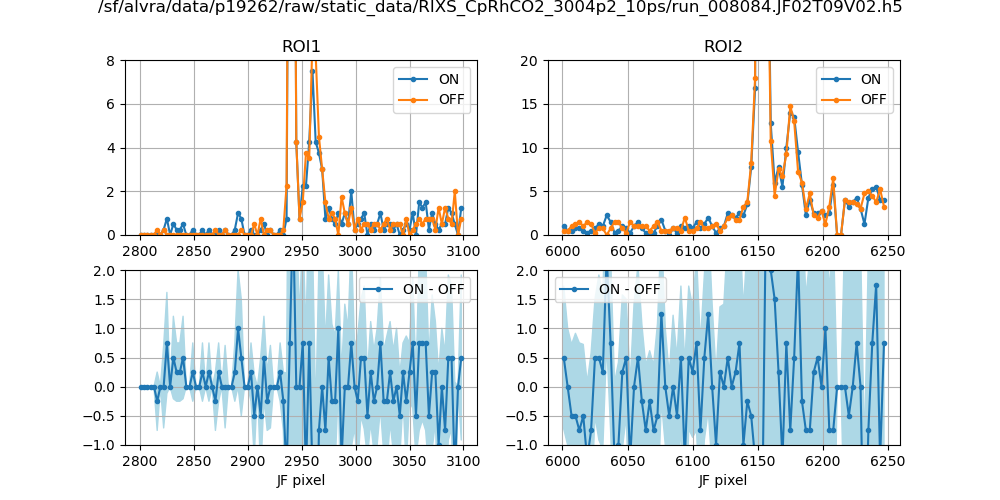

In [55]:
spectrum_ON_roi1 = np.mean(spectrum_ON_roi1_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_ON_roi2_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_ON_roi3_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_ON_roi4_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_OFF_roi1_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_OFF_roi2_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_OFF_roi3_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_OFF_roi4_all, axis = 0)


from textwrap import wrap
bin1_ = 3  # change the bin size if wanted, 1 is every pixel
bin3_ = 3  # change the bin size if wanted, 1 is every pixel

spectra_on1 = spectrum_ON_roi1# - spectrum_ON_roi2       #bkg subtraction roi1 ON 
spectra_off1 = spectrum_OFF_roi1# - spectrum_OFF_roi2    #bkg subtraction roi1 OFF
spectra_on3 = spectrum_ON_roi3# - spectrum_ON_roi4       #bkg subtraction roi3 ON 
spectra_off3 = spectrum_OFF_roi3# - spectrum_OFF_roi4    #bkg subtraction roi3 OFF

x_axis1 = np.arange(roi1[0], roi1[1])
x_axis3 = np.arange(roi3[0], roi3[1])

spectra_on_rebin1  = bin_sum(spectra_on1,  bin1_)
spectra_off_rebin1 = bin_sum(spectra_off1, bin1_)
x_axis_rebin1 = bin_mean(x_axis1, bin1_)
spectra_on_rebin3  = bin_sum(spectra_on3,  bin3_)
spectra_off_rebin3 = bin_sum(spectra_off3, bin3_)
x_axis_rebin3 = bin_mean(x_axis3, bin3_)

spectra_on_err1  = np.sqrt(abs(spectra_on_rebin1))
spectra_off_err1 = np.sqrt(abs(spectra_off_rebin1))
spectra_on_err3  = np.sqrt(abs(spectra_on_rebin3))
spectra_off_err3 = np.sqrt(abs(spectra_off_rebin3))

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
low_err3= (spectra_on_rebin3 - spectra_off_rebin3)-np.sqrt(spectra_on_err3**2+spectra_off_err3**2)
high_err3= (spectra_on_rebin3 - spectra_off_rebin3)+np.sqrt(spectra_on_err3**2+spectra_off_err3**2)

plt.figure(figsize=(10,5))
plt.suptitle(JF_single_file, y = 1)

plt.subplot(221)
plt.title('ROI1')
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.ylim(0,8)
plt.grid()

plt.subplot(223)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.ylim(-1,2)
plt.grid()

plt.subplot(222)
plt.title('ROI2')
#plt.gca().set_title("\n".join(wrap('ROI2: {} Energy = {} eV'.format(roi2, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI2: [], Delay = {} ps'.format(roi2, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin3, spectra_on_rebin3, label="ON", marker='.')
plt.plot(x_axis_rebin3, spectra_off_rebin3, label="OFF", marker='.')
plt.legend(loc="best")
plt.ylim(0,20)
plt.grid()

plt.subplot(224)
plt.plot(x_axis_rebin3,spectra_on_rebin3 - spectra_off_rebin3, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin3, low_err3, high_err3, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.ylim(-1,2)
plt.grid()

plt.show()

## Next cells for scans, ONLY JF file!

In [81]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [82]:
roi1 = (2800, 3200, 200, 260) #signal 1
roi2 = (2800, 3200, 100, 160) #bkg 1

roi3 = (6000, 6200, 200, 240) #signal 2
roi4 = (6000, 6200, 100, 140) #bkg 2

threshold_low = 2.0
threshold_high = 20

channel_list = ['JF02T09V02']

######################################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

RIXS_unpumped_roi1 = []
RIXS_pumped_roi1 = []
RIXS_transient_roi1 = []

RIXS_unpumped_roi3 = []
RIXS_pumped_roi3 = []
RIXS_transient_roi3 = []

for i, step in enumerate(scan.files):
    
    fn = step[3]
    print("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))
    
    spectrum_ON_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_ON_roi3 = 0
    spectrum_ON_roi4 = 0
    spectrum_OFF_roi1 = 0
    spectrum_OFF_roi2 = 0
    spectrum_OFF_roi3 = 0
    spectrum_OFF_roi4 = 0
    XES_transient_roi1 = 0
    XES_transient_roi3 = 0

    
    nshots = None
    
    images_pump_roi1, images_pump_roi2, images_pump_roi3, images_pump_roi4, pids_ON, \
    images_unpump_roi1, images_unpump_roi2, images_unpump_roi3, images_unpump_roi4, pids_OFF = \
    load_crop_JF_batches_on_off_4rois(fn, roi1, roi2, roi3, roi4, 100, 50, nshots=nshots)
    
    
    images_pump_roi1_thr = process_image(images_pump_roi1, threshold_low, threshold_high)
    images_unpump_roi1_thr = process_image(images_unpump_roi1, threshold_low, threshold_high)

    images_pump_roi2_thr = process_image(images_pump_roi2, threshold_low, threshold_high)
    images_unpump_roi2_thr = process_image(images_unpump_roi2, threshold_low, threshold_high)

    images_pump_roi3_thr = process_image(images_pump_roi3, threshold_low, threshold_high)
    images_unpump_roi3_thr = process_image(images_unpump_roi3, threshold_low, threshold_high)

    images_pump_roi4_thr = process_image(images_pump_roi4, threshold_low, threshold_high)
    images_unpump_roi4_thr = process_image(images_unpump_roi4, threshold_low, threshold_high)
    
    spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi3 = images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi3 = images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi4 = images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi4 = images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1 - spectrum_OFF_roi2)
    RIXS_pumped_roi1.append(spectrum_ON_roi1 - spectrum_ON_roi2)
    XES_transient_roi1 = (spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2)
    RIXS_transient_roi1.append(XES_transient_roi1)
    
    RIXS_unpumped_roi3.append(spectrum_OFF_roi3 - spectrum_OFF_roi4)
    RIXS_pumped_roi3.append(spectrum_ON_roi3 - spectrum_ON_roi4)
    XES_transient_roi3 = (spectrum_ON_roi3 - spectrum_ON_roi4) - (spectrum_OFF_roi3 - spectrum_OFF_roi4)
    RIXS_transient_roi3.append(XES_transient_roi3)
    
    clear_output(wait=True)
    print ("It took", clock.tick(), "seconds to process this file")


RIXS_unpumped_roi1 = np.asarray(RIXS_unpumped_roi1)
RIXS_pumped_roi1 = np.asarray(RIXS_pumped_roi1)
RIXS_transient_roi1 = np.asarray(RIXS_transient_roi1)

RIXS_unpumped_roi3 = np.asarray(RIXS_unpumped_roi3)
RIXS_pumped_roi3 = np.asarray(RIXS_pumped_roi3)
RIXS_transient_roi3 = np.asarray(RIXS_transient_roi3)

print ("\nJob done! It took", clock.tock(), "seconds to process", len(scan.files), "file(s)")

It took 5.55 seconds to process this file

Job done! It took 1486.96 seconds to process 51 file(s)


<IPython.core.display.Javascript object>


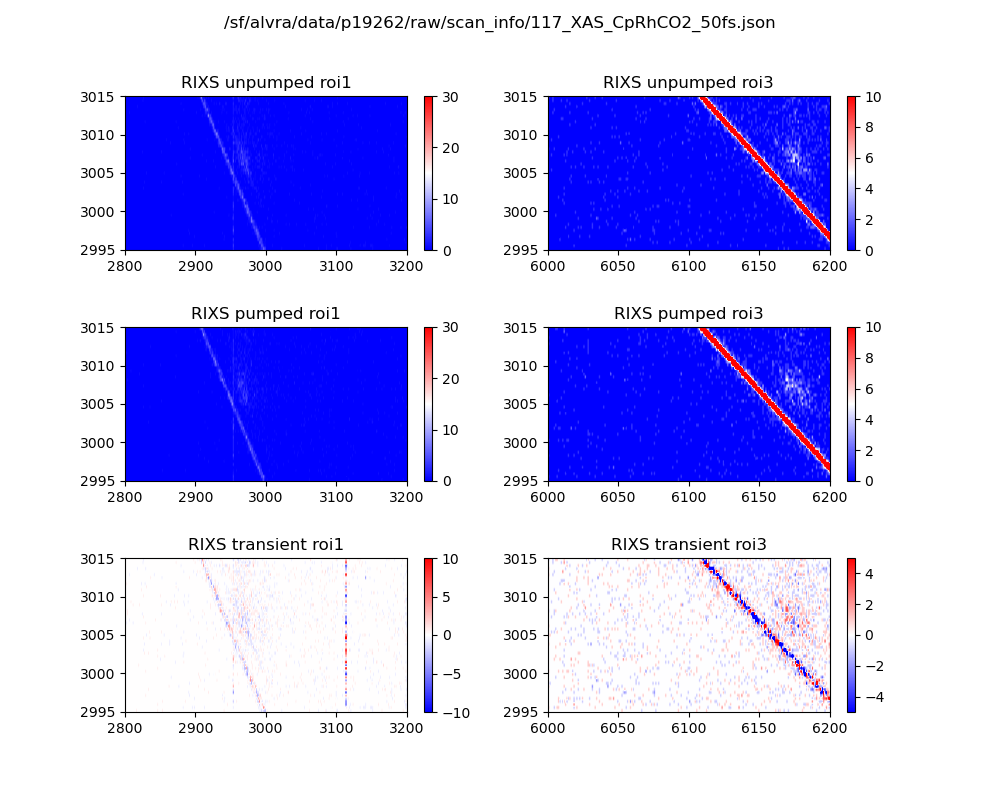

In [83]:
plt.figure(figsize=(10,8))
plt.suptitle(fc.selected)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=30)
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.title("RIXS unpumped roi3")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=30)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.title("RIXS pumped roi3")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-10, vmax=10)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=-5, vmax=5)
plt.title("RIXS transient roi3")
plt.colorbar()


plt.show()

## Next cells for a single file, any channel (BSDATA & JF) 

In [3]:
# Choose a pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals) 
# if you do not want to use the closest in time

# pedestal_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
pedestal_file = None

In [4]:
datalist = []
for file in glob.glob('/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/*.BSDATA*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch_all = datalist
print (len(patch_all))
patch_all

33


['/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009082.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009083.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009084.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009085.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009086.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009087.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009088.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009089.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009090.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009091.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009092.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009093.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009094.BSDATA.h5',
 '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009095.BSDATA.h5',
 '/sf/

In [19]:
#data = SFDataFiles('/sf/alvra/data/p18938/raw/XES_jet_FeBpy_001/run_001730.*')

channel_list_pp = [channel_Events, channel_Izero117, 'JF02T09V02']
channel_list_all = channel_list_pp

roi1 = (7740, 7900, 220, 300) #signal 1
roi2 = (7740, 7900, 400, 480) #bkg 1

roi3 = (5080, 5220, 180, 280) #signal 2
roi4 = (5080, 5220, 300, 400) #bkg 2

threshold_low = 5

##########################################################
clock = Clock()

spectrum_ON_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_ON_roi3 = 0
spectrum_ON_roi4 = 0
spectrum_OFF_roi1 = 0
spectrum_OFF_roi2 = 0
spectrum_OFF_roi3 = 0
spectrum_OFF_roi4 = 0

for file in patch_all:
    clear_output(wait=True)
    data = SFDataFiles(file.replace('BSDATA', '*'))
    
    print (data.fnames)
    
    resultsPP, results, pids_pump, pids_unpump = load_data_compact_laser_pump_JF(channel_list_pp, channel_list_all, data, roi1, roi2, roi3, roi4)
    data.close()
    
    #Data_fluo_pump = resultsPP[channel_PIPS_fluo].pump
    #Data_fluo_unpump = resultsPP[channel_PIPS_fluo].unpump
    Izero_unpump = resultsPP[channel_Izero117].unpump
    Izero_pump = resultsPP[channel_Izero117].pump
    
    images_pump_roi1 = resultsPP['JFroi1'].pump / Izero_pump[:,None, None]
    images_unpump_roi1 = resultsPP['JFroi1'].unpump / Izero_unpump[:,None, None]
    images_pump_roi2 = resultsPP['JFroi2'].pump / Izero_pump[:,None, None]
    images_unpump_roi2 = resultsPP['JFroi2'].unpump / Izero_unpump[:,None, None]
    images_pump_roi3 = resultsPP['JFroi3'].pump / Izero_pump[:,None, None]
    images_unpump_roi3 = resultsPP['JFroi3'].unpump / Izero_unpump[:,None, None]
    images_pump_roi4 = resultsPP['JFroi4'].pump / Izero_pump[:,None, None]
    images_unpump_roi4 = resultsPP['JFroi4'].unpump / Izero_unpump[:,None, None]
    
    #Energy_eV_single = resultsPP[channel_energy].pump[0]
    
    #print (images_pump.shape, images_unpump.shape)
    
    images_pump_roi1_thr = images_pump_roi1.copy()
    images_pump_roi1_thr[images_pump_roi1 < threshold_low] = 0
    #images_pump_roi1_thr[images_pump_roi1 > threshold_high] = 0
    images_unpump_roi1_thr = images_unpump_roi1.copy()
    images_unpump_roi1_thr[images_unpump_roi1 < threshold_low] = 0
    #images_unpump_roi1_thr[images_unpump_roi1 > threshold_high] = 0
    
    images_pump_roi2_thr = images_pump_roi2.copy()
    images_pump_roi2_thr[images_pump_roi2 < threshold_low] = 0
    #images_pump_roi2_thr[images_pump_roi2 > threshold_high] = 0
    images_unpump_roi2_thr = images_unpump_roi2.copy()
    images_unpump_roi2_thr[images_unpump_roi2 < threshold_low] = 0
    #images_unpump_roi2_thr[images_unpump_roi2 > threshold_high] = 0
    
    images_pump_roi3_thr = images_pump_roi3.copy()
    images_pump_roi3_thr[images_pump_roi3 < threshold_low] = 0
    #images_pump_roi3_thr[images_pump_roi3 > threshold_high] = 0
    images_unpump_roi3_thr = images_unpump_roi3.copy()
    images_unpump_roi3_thr[images_unpump_roi3 < threshold_low] = 0
    #images_unpump_roi3_thr[images_unpump_roi3 > threshold_high] = 0
    
    images_pump_roi4_thr = images_pump_roi4.copy()
    images_pump_roi4_thr[images_pump_roi4 < threshold_low] = 0
    #images_pump_roi4_thr[images_pump_roi4 > threshold_high] = 0
    images_unpump_roi4_thr = images_unpump_roi4.copy()
    images_unpump_roi4_thr[images_unpump_roi4 < threshold_low] = 0
    #images_unpump_roi4_thr[images_unpump_roi4 > threshold_high] = 0
    
    spectrum_ON_roi1 += images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)# - images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 += images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi3 += images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)# - images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi4 += images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    spectrum_OFF_roi1 += images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)# - images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 += images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi3 += images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)# - images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi4 += images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    print ("It took", clock.tick(), "seconds to process this file")

print ("It took", clock.tock(), "seconds to process {} files".format(len(patch)))

Auto-located gain file: /sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p18938/raw/JF_pedestals/run_008336.JF02T09V02.res.h5
jungfrau file: 18:15 26.02.2021
pedestal file: 20:10 25.02.2021
    mtime difference: 22:04:47.082887
('/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009114.BSDATA.h5', '/sf/alvra/data/p18938/raw/XES_jet_800nm_slits/run_009114.JF02T09V02.h5')

--------------------------------------------------------------------------------

JF02T09V02                 539 / 1079 -> 50% loss ▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet   1079 / 1079 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS117:INTENSITY  535 / 1079 -> 50% loss ▇▇▇▇▇

over the whole data set: 535 / 1079 -> 50% loss
complete channels: 1 / 3 -> 67% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Pump scheme is 1:1
Loaded 265 pump and 265 unpump shots
It took 22.55 seconds to process this file
It took 2446.55 

In [8]:
#spectrum_ON_roi1 = 0
#spectrum_ON_roi2 = 0
#spectrum_ON_roi3 = 0
#spectrum_ON_roi4 = 0
#spectrum_OFF_roi1 = 0
#spectrum_OFF_roi2 = 0
#spectrum_OFF_roi3 = 0
#spectrum_OFF_roi4 = 0
#
#spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)
#spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
#spectrum_ON_roi3 = images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)
#spectrum_ON_roi4 = images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
#
#spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)
#spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
#spectrum_OFF_roi3 = images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)
#spectrum_OFF_roi4 = images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)

-0.00030000000000000003

<IPython.core.display.Javascript object>


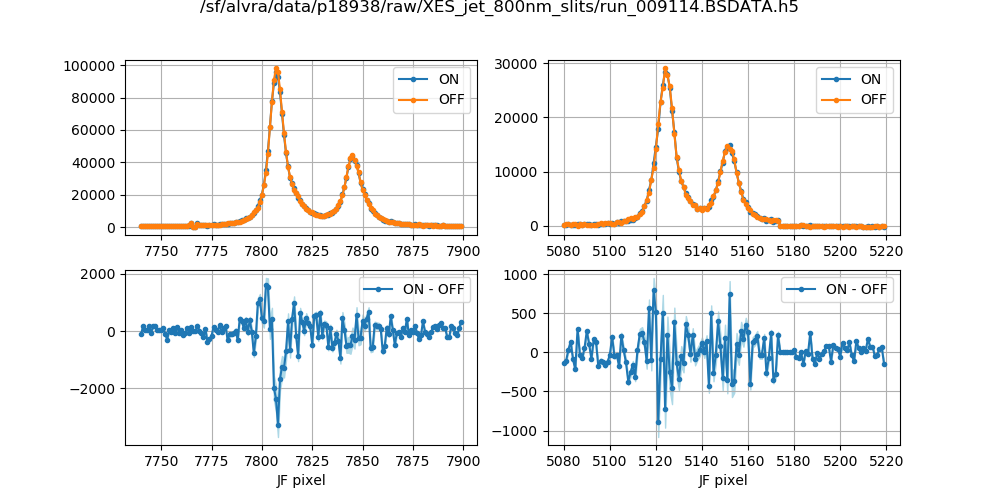

In [20]:
from textwrap import wrap
bin1_ = 1  # change the bin size if wanted, 1 is every pixel
bin3_ = 1  # change the bin size if wanted, 1 is every pixel

spectra_on1 = spectrum_ON_roi1 - spectrum_ON_roi2       #bkg subtraction roi1 ON 
spectra_off1 = spectrum_OFF_roi1 - spectrum_OFF_roi2    #bkg subtraction roi1 OFF
spectra_on3 = spectrum_ON_roi3 - spectrum_ON_roi4       #bkg subtraction roi3 ON 
spectra_off3 = spectrum_OFF_roi3 - spectrum_OFF_roi4    #bkg subtraction roi3 OFF

x_axis1 = np.arange(roi1[0], roi1[1])
x_axis3 = np.arange(roi3[0], roi3[1])

spectra_on_rebin1  = bin_sum(spectra_on1,  bin1_)
spectra_off_rebin1 = bin_sum(spectra_off1, bin1_)
x_axis_rebin1 = bin_mean(x_axis1, bin1_)
spectra_on_rebin3  = bin_sum(spectra_on3,  bin3_)
spectra_off_rebin3 = bin_sum(spectra_off3, bin3_)
x_axis_rebin3 = bin_mean(x_axis3, bin3_)

spectra_on_err1  = np.sqrt(abs(spectra_on_rebin1))
spectra_off_err1 = np.sqrt(abs(spectra_off_rebin1))
spectra_on_err3  = np.sqrt(abs(spectra_on_rebin3))
spectra_off_err3 = np.sqrt(abs(spectra_off_rebin3))

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
low_err3= (spectra_on_rebin3 - spectra_off_rebin3)-np.sqrt(spectra_on_err3**2+spectra_off_err3**2)
high_err3= (spectra_on_rebin3 - spectra_off_rebin3)+np.sqrt(spectra_on_err3**2+spectra_off_err3**2)

plt.figure(figsize=(10,5))
plt.suptitle(file, y = 1)

plt.subplot(221)

#plt.gca().set_title("\n".join(wrap('ROI1: {} Energy = {} eV'.format(roi1, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI1: [], Delay = {} ps'.format(roi1, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(223)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(222)
#plt.gca().set_title("\n".join(wrap('ROI2: {} Energy = {} eV'.format(roi2, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI2: [], Delay = {} ps'.format(roi2, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin3, spectra_on_rebin3, label="ON", marker='.')
plt.plot(x_axis_rebin3, spectra_off_rebin3, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(224)
plt.plot(x_axis_rebin3,spectra_on_rebin3 - spectra_off_rebin3, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin3, low_err3, high_err3, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.show()

## Next cells for scans, ONLY JF file!

In [3]:
fc = FileChooser('/sf/alvra/data/p19262/raw/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw/scan_info', filename='', title='HTML(value='', layout=Layout(displ…

In [26]:
roi1 = (2600, 3400, 200, 260) #signal 1 Si111
roi2 = (2600, 3400, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2 SiO2(11-20)
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2.0
threshold_high = 20

channel_list = ['JF02T09V02']

######################################################################################

from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Energy_eV = scan.readbacks

XAS_roi1 = []
XAS_roi1_on = []
#Error_XAS_roi1 = []
XAS_roi3 = []
XAS_roi3_on = []
#Error_XAS_roi3 = []

RIXS_transient_roi1 = []
RIXS_transient_roi3 = []
Error_transient_roi1 = []
Error_transient_roi3 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi3 = []
Error_unpumped_roi1 = []
Error_unpumped_roi3 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi3 = []
Error_pumped_roi1 = []
Error_pumped_roi3 = []
XAS_transient_roi1 =[]
XAS_transient_roi1_2 = []
XES_transient_roi1 =[]
XAS_transient_roi3 =[]
XES_transient_roi3 =[]

XES_abs_roi1 = []
XES_abs_roi3 = []

#XES_1D = []

clock = Clock()

#for i, (pv, bs, fn) in enumerate(scan_data):
for i, step in enumerate(scan.files):
#for i in range(0,4):
    fn = step[3]
    print("File {} out of {}: Processing {}".format(i+1, len(scan.files), fn.split('/')[-1]))
    
    
    spectrum_ON_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_ON_roi3 = 0
    spectrum_ON_roi4 = 0
    spectrum_OFF_roi1 = 0
    spectrum_OFF_roi2 = 0
    spectrum_OFF_roi3 = 0
    spectrum_OFF_roi4 = 0
    
    nshots = None  # put this to None for ALL images
    #nshots = None
    
    
    images_pump_roi1, images_pump_roi2, images_pump_roi3, images_pump_roi4, pids_ON, \
    images_unpump_roi1, images_unpump_roi2, images_unpump_roi3, images_unpump_roi4, pids_OFF = \
    load_crop_JF_batches_on_off_4rois(fn, roi1, roi2, roi3, roi4, 100, 50, nshots=nshots)
    
#   images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
#   load_crop_JF_data_on_off(fn, roi1, roi2, 50, 25, pedestal_file=pedestal_file, nshots=nshots)
    
#    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
#    energy = [x for x in energy if (x > 0)]
#    Energy_eV.append(np.mean(energy))
    
#    delay, pids = load_single_channel_pulseID(bs, channel_delay_harm, 50)
#    delay = [x for x in delay if (x > 0)]
#    Delay_mm.append(np.mean(delay))

    ##################################3
    #### ROI1 pump
    ##################################

    images_pump_roi1_thr = images_pump_roi1.copy()
    images_pump_roi1_thr[images_pump_roi1 < threshold_low] = 0
    images_pump_roi1_thr[images_pump_roi1 > threshold_high] = 0
    images_pump_roi1_thr = convert_to_photon_num_range(images_pump_roi1_thr, [threshold_low,threshold_high])

    ##################################3
    #### ROI1 unpump
    ##################################
    
    images_unpump_roi1_thr = images_unpump_roi1.copy()
    images_unpump_roi1_thr[images_unpump_roi1 < threshold_low] = 0
    images_unpump_roi1_thr[images_unpump_roi1 > threshold_high] = 0
    images_unpump_roi1_thr = convert_to_photon_num_range(images_unpump_roi1_thr, [threshold_low,threshold_high])
    
    ##################################3
    #### ROI2 pump
    ##################################
    
    images_pump_roi2_thr = images_pump_roi2.copy()
    images_pump_roi2_thr[images_pump_roi2 < threshold_low] = 0
    images_pump_roi2_thr[images_pump_roi2 > threshold_high] = 0
    images_pump_roi2_thr = convert_to_photon_num_range(images_pump_roi2_thr, [threshold_low,threshold_high])
    
    ##################################3
    #### ROI2 unpump
    ##################################
    
    images_unpump_roi2_thr = images_unpump_roi2.copy()
    images_unpump_roi2_thr[images_unpump_roi2 < threshold_low] = 0
    images_unpump_roi2_thr[images_unpump_roi2 > threshold_high] = 0
    images_unpump_roi2_thr = convert_to_photon_num_range(images_unpump_roi2_thr, [threshold_low,threshold_high])
    
    ##################################3
    #### ROI3 pump
    ##################################
    
    images_pump_roi3_thr = images_pump_roi3.copy()
    images_pump_roi3_thr[images_pump_roi3 < threshold_low] = 0
    images_pump_roi3_thr[images_pump_roi3 > threshold_high] = 0
    images_pump_roi3_thr = convert_to_photon_num_range(images_pump_roi3_thr, [threshold_low,threshold_high])

    ##################################3
    #### ROI3 unpump
    ##################################
    
    images_unpump_roi3_thr = images_unpump_roi3.copy()
    images_unpump_roi3_thr[images_unpump_roi3 < threshold_low] = 0
    images_unpump_roi3_thr[images_unpump_roi3 > threshold_high] = 0
    images_unpump_roi3_thr = convert_to_photon_num_range(images_unpump_roi3_thr, [threshold_low,threshold_high])
    
    ##################################3
    #### ROI4 pump
    ##################################
    
    images_pump_roi4_thr = images_pump_roi4.copy()
    images_pump_roi4_thr[images_pump_roi4 < threshold_low] = 0
    images_pump_roi4_thr[images_pump_roi4 > threshold_high] = 0
    images_pump_roi4_thr = convert_to_photon_num_range(images_pump_roi4_thr, [threshold_low,threshold_high])    

    ##################################3
    #### ROI4 unpump
    ##################################
    
    images_unpump_roi4_thr = images_unpump_roi4.copy()
    images_unpump_roi4_thr[images_unpump_roi4 < threshold_low] = 0
    images_unpump_roi4_thr[images_unpump_roi4 > threshold_high] = 0
    images_unpump_roi4_thr = convert_to_photon_num_range(images_unpump_roi4_thr, [threshold_low,threshold_high])
    
    
    spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi3 = images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi3 = images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi4 = images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi4 = images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)

######################### ROI 1 & 2 ##############################################
    
    XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum() - spectrum_OFF_roi2.sum()))
    XAS_roi1_on.append(np.abs(spectrum_ON_roi1.sum() - spectrum_ON_roi2.sum()))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1 - spectrum_OFF_roi2)
 #   Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1 - spectrum_ON_roi2)
 #   Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))

    XES_transient_roi1 = (spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2)
    
    RIXS_transient_roi1.append(XES_transient_roi1)
 #   Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    XES_abs_roi1 = np.abs(XES_transient_roi1)
    
 #   XES_1D.append(np.sum(XES_transient_roi1, axis = 1))
    
    XAS_transient_roi1.append(np.sum(XES_abs_roi1[50:80]))
    XAS_transient_roi1_2.append(np.abs(np.sum(XES_transient_roi1[55:63])) + np.abs(np.sum(XES_transient_roi1[64:75])))
    
######################### ROI 3 & 4 ##############################################
    
    XAS_roi3.append(np.abs(spectrum_OFF_roi3.sum() - spectrum_OFF_roi4.sum()))
    XAS_roi3_on.append(np.abs(spectrum_ON_roi3.sum() - spectrum_ON_roi4.sum()))
    RIXS_unpumped_roi3.append(spectrum_OFF_roi3 - spectrum_OFF_roi4)
 #   Error_unpumped_roi3.append(np.sqrt(spectrum_OFF_roi3))
    RIXS_pumped_roi3.append(spectrum_ON_roi3 - spectrum_ON_roi4)
 #   Error_pumped_roi3.append(np.sqrt(spectrum_ON_roi3))

    XES_transient_roi3 = (spectrum_ON_roi3 - spectrum_ON_roi4) - (spectrum_OFF_roi3 - spectrum_OFF_roi4)
    
    RIXS_transient_roi3.append(XES_transient_roi3)
 #   Error_transient_roi3.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    XES_abs_roi3 = np.abs(XES_transient_roi3)
 #   XES_1D.append(np.sum(XES_transient_roi3, axis = 1))
    
    XAS_transient_roi3.append(np.sum(XES_abs_roi3))
    
    clear_output(wait=True)
    
    print ("It took {} to process file {}".format(clock.tick(), fn.split('/')[-1]))

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
XAS_roi1_on = np.array(XAS_roi1_on)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)
XAS_transient_roi1=np.array(XAS_transient_roi1)
XAS_transient_roi1_2=np.array(XAS_transient_roi1_2)
XES_transient_roi1=np.array(XES_transient_roi1)
#XES_1D=np.array(XES_1D)
XAS_roi3 = np.array(XAS_roi3)
XAS_roi3_on = np.array(XAS_roi3_on)
RIXS_unpumped_roi3 = np.array(RIXS_unpumped_roi3)
Error_unpumped_roi3 = np.array(Error_unpumped_roi3)
RIXS_pumped_roi3 = np.array(RIXS_pumped_roi3)
Error_pumped_roi3 = np.array(Error_pumped_roi3)
RIXS_transient_roi3 = np.array(RIXS_transient_roi3)
Error_transient_roi3 = np.array(Error_transient_roi3)
XAS_transient_roi3=np.array(XAS_transient_roi3)
XES_transient_roi3=np.array(XES_transient_roi3)
#XES_1D=np.array(XES_1D)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")



It took 5.73 to process file run_005513.JF02T09V02.h5

Job done! It took 281.52 seconds to process 37 file(s)


<IPython.core.display.Javascript object>


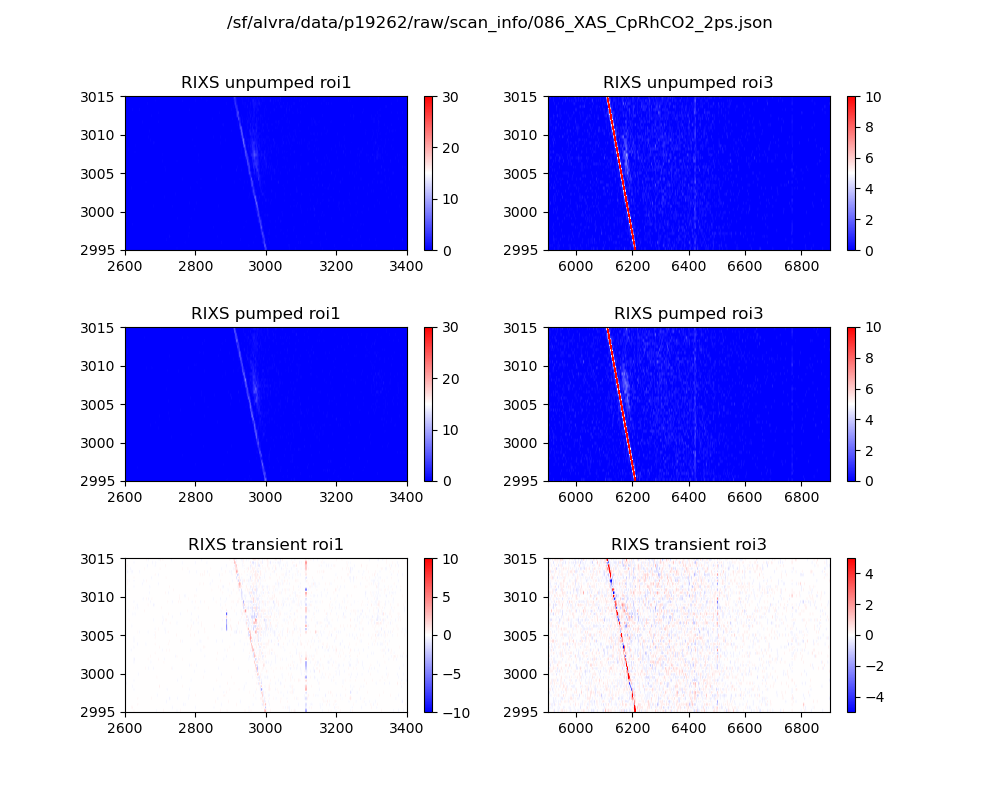

In [31]:
plt.figure(figsize=(10,8))
plt.suptitle(fc.selected)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=30)
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.title("RIXS unpumped roi3")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=30)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=0, vmax=10)
plt.title("RIXS pumped roi3")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-10, vmax=10)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=-5, vmax=5)
plt.title("RIXS transient roi3")
plt.colorbar()



plt.show()

<IPython.core.display.Javascript object>


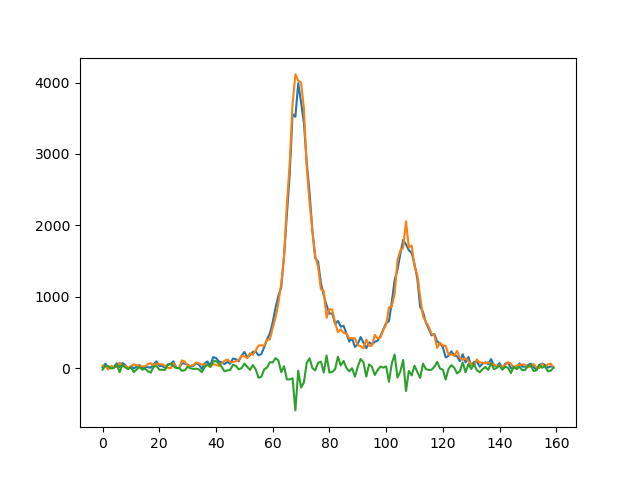

3151.3267


In [281]:
#XES_transient_roi1 = (spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2)
#XES_abs_roi1 = np.abs((spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2))

point = -1

plt.figure()
plt.plot(RIXS_pumped_roi1[point])
plt.plot(RIXS_unpumped_roi1[point])
#plt.plot(XES_transient_roi1)
plt.plot(RIXS_transient_roi1[point])
#plt.plot(XES_abs_roi1)
plt.show()
print (np.sum(XES_abs_roi1[50:80]))

<IPython.core.display.Javascript object>


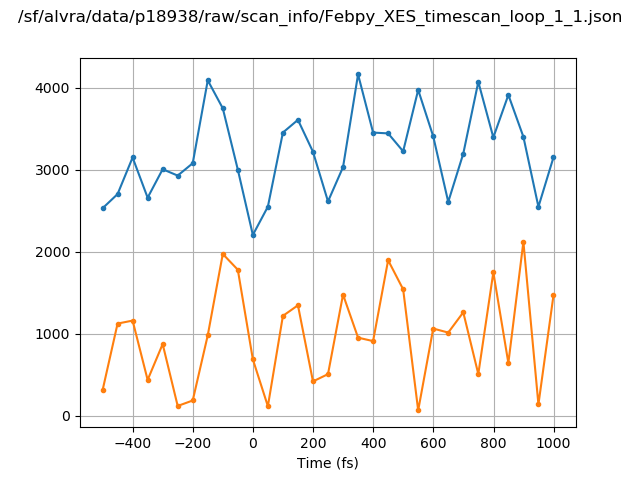

In [282]:
Delay_fs = (Delay_mm - 235.7348)*2/(3e8*1e3*1e-15)
plt.figure()
plt.suptitle(json_file)
plt.plot(Delay_fs, XAS_transient_roi1, marker='.')
plt.plot(Delay_fs, XAS_transient_roi1_2, marker='.')
plt.xlabel ('Time (fs)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


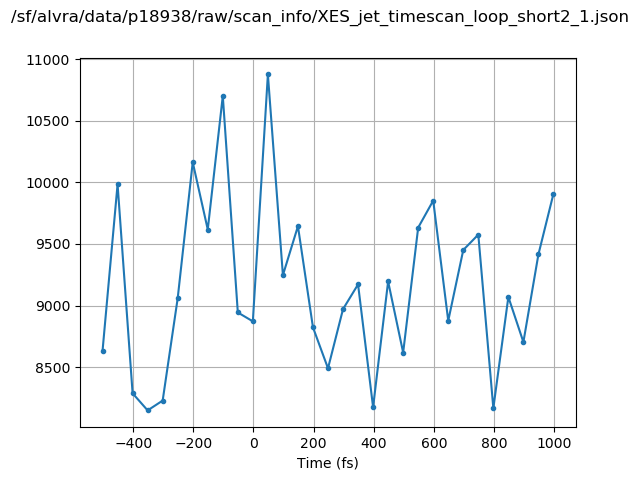

In [209]:
Delay_fs = (Delay_mm - 236.01282)*2/(3e8*1e3*1e-15)
plt.figure()
plt.suptitle(json_file)
plt.plot(Delay_fs, XAS_transient_roi1, marker='.')
plt.xlabel ('Time (fs)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


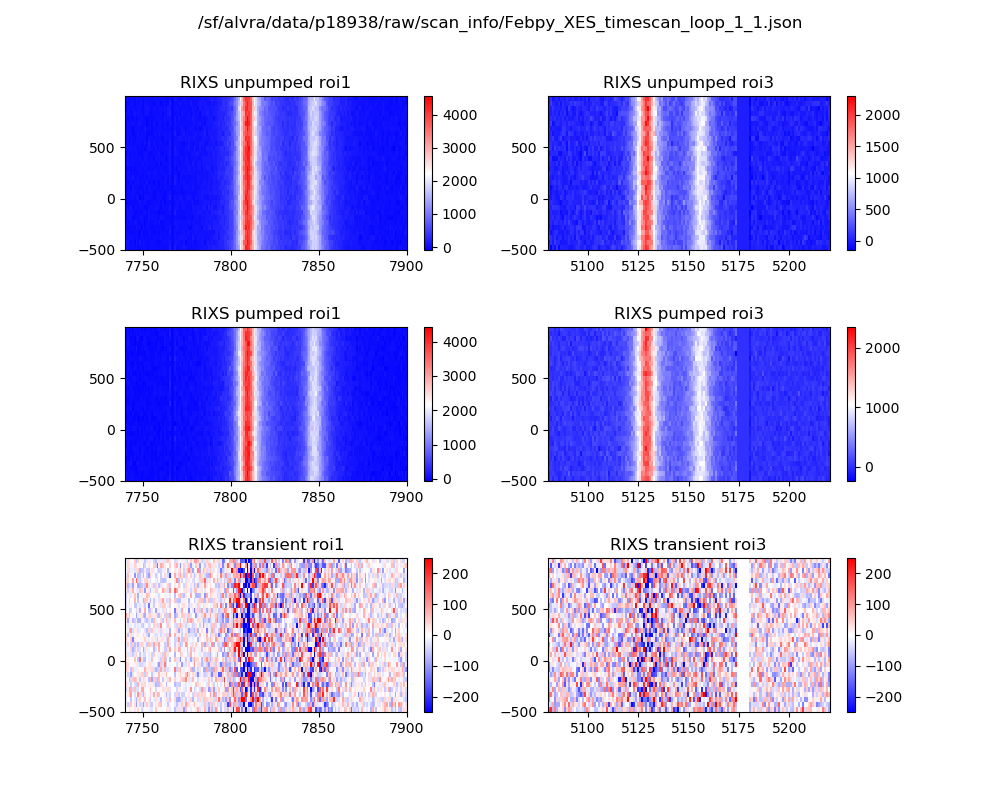

In [283]:
plt.figure(figsize=(10,8))
plt.suptitle(fc.selected)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Delay_fs[0], Delay_fs[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Delay_fs[0], Delay_fs[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS unpumped roi3")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Delay_fs[0], Delay_fs[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Delay_fs[0], Delay_fs[-1]])
plt.title("RIXS pumped roi3")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Delay_fs[0], Delay_fs[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi3, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Delay_fs[0], Delay_fs[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi3")
plt.colorbar()



plt.show()

<IPython.core.display.Javascript object>


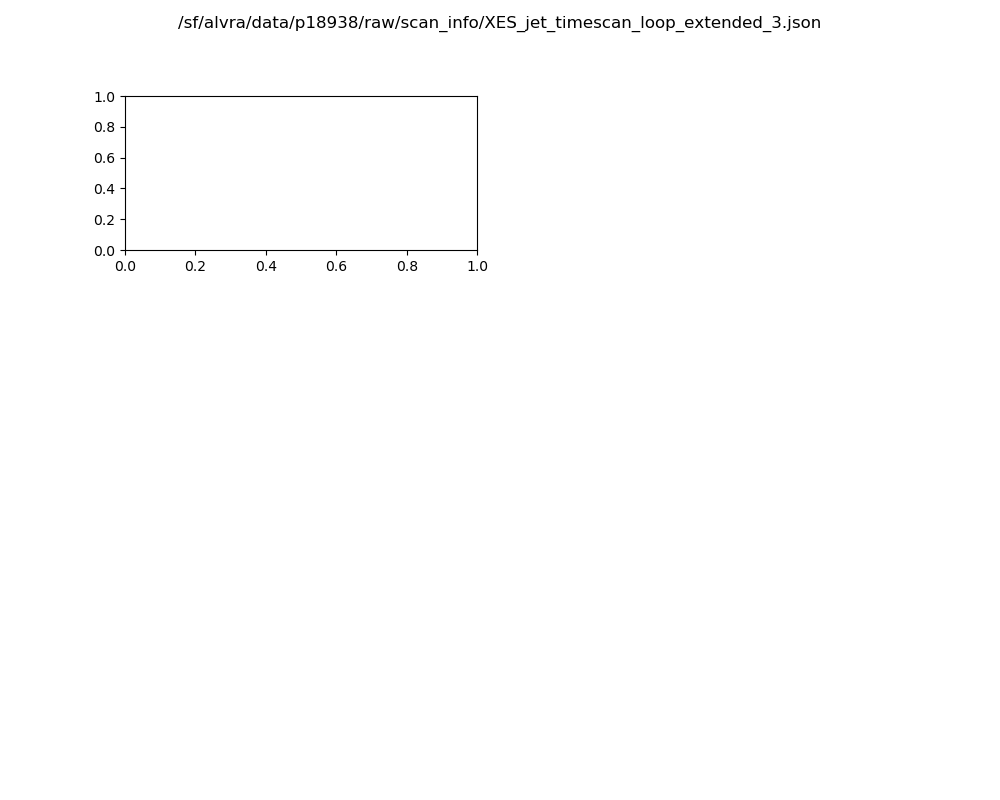

IndexError: index 0 is out of bounds for axis 0 with size 0

In [164]:
plt.figure(figsize=(10,8))
plt.suptitle(fc.selected)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS unpumped roi2")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS pumped roi2")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi2")
plt.colorbar()



plt.show()

In [36]:
len(scan.files)

51

## Next cells for loops, ONLY JF file!

In [61]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p19262/raw/scan_info/*XAS_CpRhCO2_10ps*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles
patch

['/sf/alvra/data/p19262/raw/scan_info/049_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/050_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/053_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/054_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/055_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/056_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/057_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/058_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/072_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/078_XAS_CpRhCO2_10ps.json',
 '/sf/alvra/data/p19262/raw/scan_info/082_XAS_CpRhCO2_10ps.json']

In [62]:
roi1 = (2800, 3100, 200, 260) #signal 1 Si111
roi2 = (2800, 3100, 100, 160) #bkg 1

roi3 = (5900, 6900, 200, 260) #signal 2 SiO2(11-20)
roi4 = (5900, 6900, 100, 160) #bkg 2

threshold_low = 2.0
threshold_high = 20

channel_list = ['JF02T09V02']

######################################################################################
#outdir = '/sf/alvra/data/p18938/res/Claudio/'

XAS_total_roi1 = 0
XAS_total_roi3 = 0

RIXS_total_roi1 = []
RIXS_total_roi3 = []

clock2 = Clock()

for json_file in patch:
    
    from sfdata import SFScanInfo
    scan = SFScanInfo(json_file)
    Energy_eV = scan.readbacks
        
    RIXS_transient_roi1 = []
    RIXS_transient_roi3 = []
    Error_transient_roi1 = []
    Error_transient_roi3 = []
    RIXS_unpumped_roi1 = []
    RIXS_unpumped_roi3 = []
    Error_unpumped_roi1 = []
    Error_unpumped_roi3 = []
    RIXS_pumped_roi1 = []
    RIXS_pumped_roi3 = []
    Error_pumped_roi1 = []
    Error_pumped_roi3 = []
    XAS_transient_roi1 =[]
    XES_transient_roi1 =[]
    XAS_transient_roi3 =[]
    XES_transient_roi3 =[]
    XAS_roi1 = []
    XAS_roi3 = []
    XAS_roi1_on = []
    XAS_roi3_on = []
        
    XES_abs_roi1 = []
    XES_abs_roi3 = []
    
    clock1 = Clock()
    
    num_scan_files = len(scan.files)
    print("\nProcessing", num_scan_files, "total files")
    
    for i, step in enumerate(scan.files):
    #for i in range(0,4):
        fn = step[3]
        print('scan file is {}'.format(json_file.split('/')[-1]))
        print("\n File {} out of {}: Processing {}".format(i+1, num_scan_files, fn.split('/')[-1:]))
        
        spectrum_ON_roi1 = 0
        spectrum_ON_roi2 = 0
        spectrum_ON_roi3 = 0
        spectrum_ON_roi4 = 0
        spectrum_OFF_roi1 = 0
        spectrum_OFF_roi2 = 0
        spectrum_OFF_roi3 = 0
        spectrum_OFF_roi4 = 0
        
        nshots = None  # put this to None for ALL images
        #nshots = None
        
        
        images_pump_roi1, images_pump_roi2, images_pump_roi3, images_pump_roi4, pids_ON, \
        images_unpump_roi1, images_unpump_roi2, images_unpump_roi3, images_unpump_roi4, pids_OFF = \
        load_crop_JF_batches_on_off_4rois(fn, roi1, roi2, roi3, roi4, 100, 50, nshots=nshots)
        
        images_pump_roi1_thr = images_pump_roi1.copy()
        images_pump_roi1_thr[images_pump_roi1 < threshold_low] = 0
        images_pump_roi1_thr[images_pump_roi1 > threshold_high] = 0
        images_pump_roi1_thr = convert_to_photon_num_range(images_pump_roi1_thr, [threshold_low,threshold_high])

        ##################################3
        #### ROI1 unpump
        ##################################

        images_unpump_roi1_thr = images_unpump_roi1.copy()
        images_unpump_roi1_thr[images_unpump_roi1 < threshold_low] = 0
        images_unpump_roi1_thr[images_unpump_roi1 > threshold_high] = 0
        images_unpump_roi1_thr = convert_to_photon_num_range(images_unpump_roi1_thr, [threshold_low,threshold_high])

        ##################################3
        #### ROI2 pump
        ##################################

        images_pump_roi2_thr = images_pump_roi2.copy()
        images_pump_roi2_thr[images_pump_roi2 < threshold_low] = 0
        images_pump_roi2_thr[images_pump_roi2 > threshold_high] = 0
        images_pump_roi2_thr = convert_to_photon_num_range(images_pump_roi2_thr, [threshold_low,threshold_high])

        ##################################3
        #### ROI2 unpump
        ##################################

        images_unpump_roi2_thr = images_unpump_roi2.copy()
        images_unpump_roi2_thr[images_unpump_roi2 < threshold_low] = 0
        images_unpump_roi2_thr[images_unpump_roi2 > threshold_high] = 0
        images_unpump_roi2_thr = convert_to_photon_num_range(images_unpump_roi2_thr, [threshold_low,threshold_high])

        ##################################3
        #### ROI3 pump
        ##################################

        images_pump_roi3_thr = images_pump_roi3.copy()
        images_pump_roi3_thr[images_pump_roi3 < threshold_low] = 0
        images_pump_roi3_thr[images_pump_roi3 > threshold_high] = 0
        images_pump_roi3_thr = convert_to_photon_num_range(images_pump_roi3_thr, [threshold_low,threshold_high])

        ##################################3
        #### ROI3 unpump
        ##################################

        images_unpump_roi3_thr = images_unpump_roi3.copy()
        images_unpump_roi3_thr[images_unpump_roi3 < threshold_low] = 0
        images_unpump_roi3_thr[images_unpump_roi3 > threshold_high] = 0
        images_unpump_roi3_thr = convert_to_photon_num_range(images_unpump_roi3_thr, [threshold_low,threshold_high])

        ##################################3
        #### ROI4 pump
        ##################################

        images_pump_roi4_thr = images_pump_roi4.copy()
        images_pump_roi4_thr[images_pump_roi4 < threshold_low] = 0
        images_pump_roi4_thr[images_pump_roi4 > threshold_high] = 0
        images_pump_roi4_thr = convert_to_photon_num_range(images_pump_roi4_thr, [threshold_low,threshold_high])    

        ##################################3
        #### ROI4 unpump
        ##################################

        images_unpump_roi4_thr = images_unpump_roi4.copy()
        images_unpump_roi4_thr[images_unpump_roi4 < threshold_low] = 0
        images_unpump_roi4_thr[images_unpump_roi4 > threshold_high] = 0
        images_unpump_roi4_thr = convert_to_photon_num_range(images_unpump_roi4_thr, [threshold_low,threshold_high])

        spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_ON_roi3 = images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi3 = images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_ON_roi4 = images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi4 = images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)

    ######################### ROI 1 & 2 ##############################################
        
        XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum() - spectrum_OFF_roi2.sum()))
        XAS_roi1_on.append(np.abs(spectrum_ON_roi1.sum() - spectrum_ON_roi2.sum()))
        RIXS_unpumped_roi1.append(spectrum_OFF_roi1 - spectrum_OFF_roi2)
     #   Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
        RIXS_pumped_roi1.append(spectrum_ON_roi1 - spectrum_ON_roi2)
     #   Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    
        XES_transient_roi1 = (spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2)
        
        RIXS_transient_roi1.append(XES_transient_roi1)
     #   Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
      
        XES_abs_roi1 = np.abs(XES_transient_roi1)
        
     #   XES_1D.append(np.sum(XES_transient_roi1, axis = 1))
        
        XAS_transient_roi1.append(np.sum(XES_abs_roi1[50:80]))
        
    ######################### ROI 3 & 4 ##############################################
        
        XAS_roi3.append(np.abs(spectrum_OFF_roi3.sum() - spectrum_OFF_roi4.sum()))
        XAS_roi3_on.append(np.abs(spectrum_ON_roi3.sum() - spectrum_ON_roi4.sum()))
        RIXS_unpumped_roi3.append(spectrum_OFF_roi3 - spectrum_OFF_roi4)
     #   Error_unpumped_roi3.append(np.sqrt(spectrum_OFF_roi3))
        RIXS_pumped_roi3.append(spectrum_ON_roi3 - spectrum_ON_roi4)
     #   Error_pumped_roi3.append(np.sqrt(spectrum_ON_roi3))
    
        XES_transient_roi3 = (spectrum_ON_roi3 - spectrum_ON_roi4) - (spectrum_OFF_roi3 - spectrum_OFF_roi4)
        
        RIXS_transient_roi3.append(XES_transient_roi3)
     #   Error_transient_roi3.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
        
        XES_abs_roi3 = np.abs(XES_transient_roi3)
     #   XES_1D.append(np.sum(XES_transient_roi3, axis = 1))
        
        XAS_transient_roi3.append(np.sum(XES_abs_roi3))
        
        clear_output(wait=True)
        
        print ("It took {} to process file {}".format(clock1.tick(), fn.split('/')[-1]))
        
    filename_h5 = savedir + json_file.split('/')[-1].split('.')[0] + "_export.h5" 
    with h5py.File(filename_h5, "w") as file2write:
        file2write.create_dataset("RIXS_pumped_roi1", data = RIXS_pumped_roi1)
        file2write.create_dataset("RIXS_unpumped_roi1", data = RIXS_unpumped_roi1)
        file2write.create_dataset("RIXS_transient_roi1", data = RIXS_transient_roi1)
        file2write.create_dataset("RIXS_pumped_roi3", data = RIXS_pumped_roi3)
        file2write.create_dataset("RIXS_unpumped_roi3", data = RIXS_unpumped_roi3)
        file2write.create_dataset("RIXS_transient_roi3", data = RIXS_transient_roi3)        
    print(filename_h5)
    
    RIXS_total_roi1.append(RIXS_transient_roi1)
    RIXS_total_roi3.append(RIXS_transient_roi3)
    
    XAS_total_roi1 += np.array(XAS_transient_roi1)
    XAS_total_roi3 += np.array(XAS_transient_roi3)
    
    
    print ("\nJob done! It took", clock1.tock(), "seconds to process", num_scan_files, "file(s)")

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
XAS_roi1_on = np.array(XAS_roi1_on)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)
XAS_transient_roi1=np.array(XAS_transient_roi1)
XES_transient_roi1=np.array(XES_transient_roi1)
#XES_1D=np.array(XES_1D)
XAS_roi3 = np.array(XAS_roi3)
XAS_roi3_on = np.array(XAS_roi3_on)
RIXS_unpumped_roi3 = np.array(RIXS_unpumped_roi3)
Error_unpumped_roi3 = np.array(Error_unpumped_roi3)
RIXS_pumped_roi3 = np.array(RIXS_pumped_roi3)
Error_pumped_roi3 = np.array(Error_pumped_roi3)
RIXS_transient_roi3 = np.array(RIXS_transient_roi3)
Error_transient_roi3 = np.array(Error_transient_roi3)
XAS_transient_roi3=np.array(XAS_transient_roi3)
XES_transient_roi3=np.array(XES_transient_roi3)
#XES_1D=np.array(XES_1D)

RIXS_total_roi1 = np.asarray(RIXS_total_roi1)
RIXS_total_roi3 = np.asarray(RIXS_total_roi3)


XAS_total_roi1 = np.asarray(XAS_total_roi1)
XAS_total_roi3 = np.asarray(XAS_total_roi3)

print ("\nJob done! It took", clock2.tick(), "seconds to process {} json files".format(len(patch)))


It took 7.85 to process file run_003994.JF02T09V02.h5
/das/work/p19/p19262/Claudio/Reduced_data/053_XAS_CpRhCO2_10ps_export.h5


ValueError: operands could not be broadcast together with shapes (37,) (68,) (37,) 

In [51]:
np.shape(RIXS_total_roi1)

(2, 37, 800)

<IPython.core.display.Javascript object>


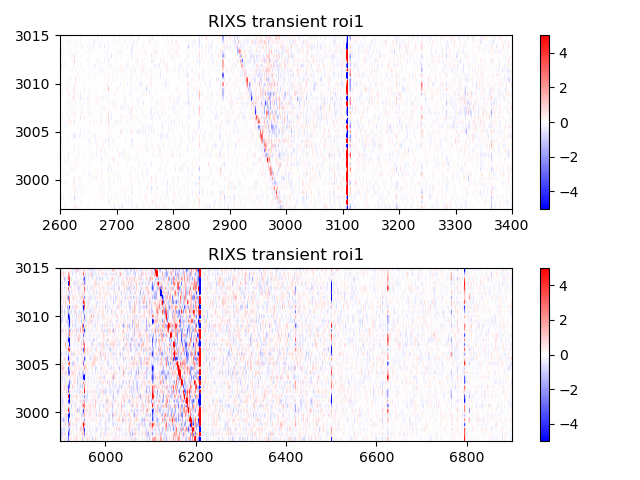

In [54]:
plt.figure()

plt.subplot(211)
plt.imshow(np.mean(RIXS_total_roi1, axis=0), aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-5, vmax=5)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(212)
plt.imshow(np.mean(RIXS_total_roi3, axis=0), aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi3[0], roi3[1], Energy_eV[0], Energy_eV[-1]], vmin=-5, vmax=5)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.tight_layout()
plt.show()

In [471]:
loadfiles = []
for file in glob.glob('/sf/alvra/data/p18938/res/Claudio/Febpy_XES_*'):
    loadfiles.append(file)
loadfiles = sorted(loadfiles, key = os.path.getmtime)
loadfiles

['/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_1_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_2_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_3_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_4_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_1_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_2_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_3_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_4_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_5_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_6_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_7_export.h5',
 '/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_8_export.h5']

In [472]:
Delay_mm = load_scan_readback('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_loop_1_2.json')

all_files = 0

for fn in loadfiles:
    print (fn)
    with h5py.File(fn, "r") as file2open:
        RIXS_pumped_roi1 = file2open['RIXS_pumped_roi1'][:]
        RIXS_unpumped_roi1 = file2open['RIXS_unpumped_roi1'][:]
        RIXS_transient_roi1 = file2open['RIXS_transient_roi1'][:]
        RIXS_pumped_roi3 = file2open['RIXS_pumped_roi3'][:]
        RIXS_unpumped_roi3 = file2open['RIXS_unpumped_roi3'][:]
        RIXS_transient_roi3 = file2open['RIXS_transient_roi3'][:]
    
    all_files +=  RIXS_transient_roi1
    #all_files +=  RIXS_pumped_roi1

/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_1_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_2_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_3_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_1_4_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_1_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_2_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_3_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_4_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_5_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_6_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_7_export.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_loop_2_8_export.h5


<IPython.core.display.Javascript object>


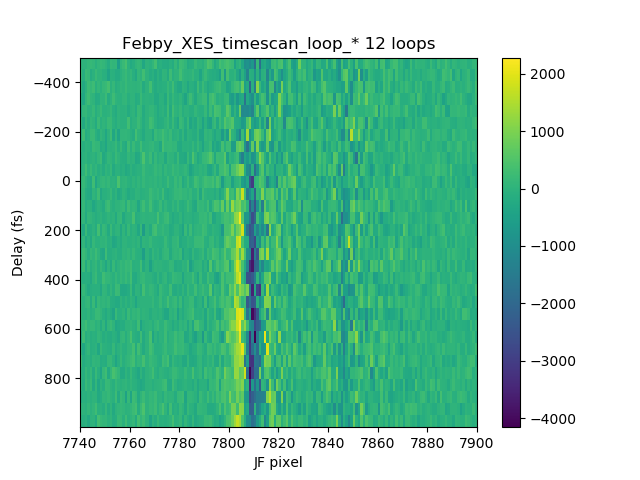

In [473]:
plt.figure()
plt.imshow(all_files, aspect='auto', extent=[roi1[0], roi1[1], Delay_fs[-1], Delay_fs[0]])
plt.title('Febpy_XES_timescan_loop_* {} loops'.format(len(loadfiles)))
plt.colorbar()
plt.ylabel('Delay (fs)')
plt.xlabel('JF pixel')
plt.show()

<IPython.core.display.Javascript object>


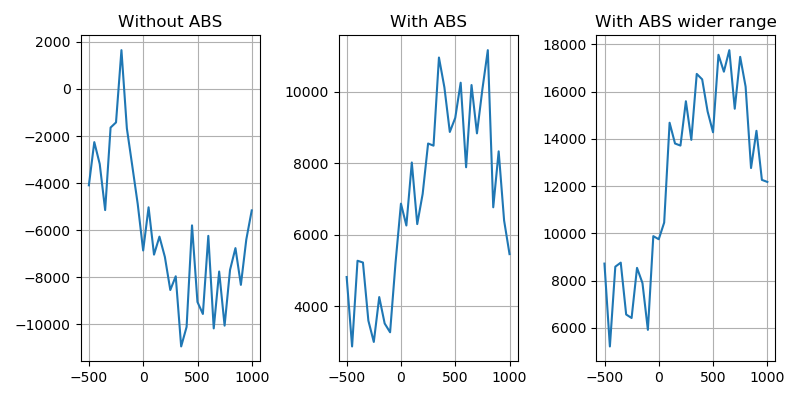

In [466]:
Delay_fs = (Delay_mm - 235.7348)*2/(3e8*1e3*1e-15)

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,3,1)
ax1.set_title('Without ABS')
ax1.plot(Delay_fs, all_files[:,66:72].sum(axis = 1))
ax1.grid()
ax2 = fig.add_subplot(1,3,2)
ax2.set_title('With ABS')
ax2.plot(Delay_fs, np.abs(all_files[:,66:72]).sum(axis = 1))
ax2.grid()
ax3 = fig.add_subplot(1,3,3)
ax3.set_title('With ABS wider range')
ax3.plot(Delay_fs, np.abs(all_files[:,60:75]).sum(axis = 1))
ax3.grid()

plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


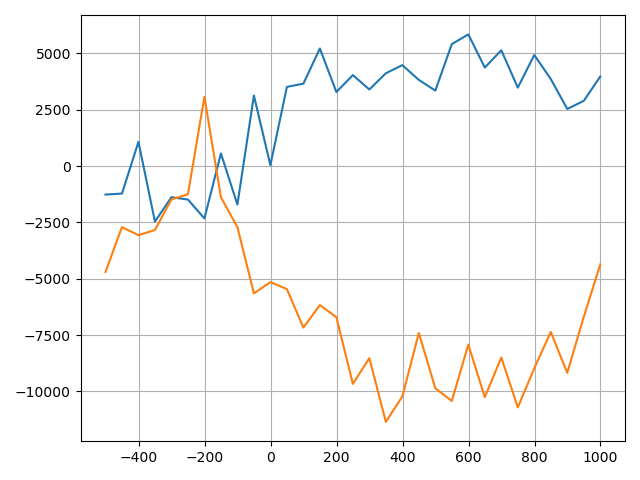

In [467]:
Delay_fs = (Delay_mm - 235.7348)*2/(3e8*1e3*1e-15)

plt.figure()
plt.plot(Delay_fs, (all_files[:,62:67]).sum(axis = 1))
plt.plot(Delay_fs, (all_files[:,67:73]).sum(axis = 1))
plt.grid()

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


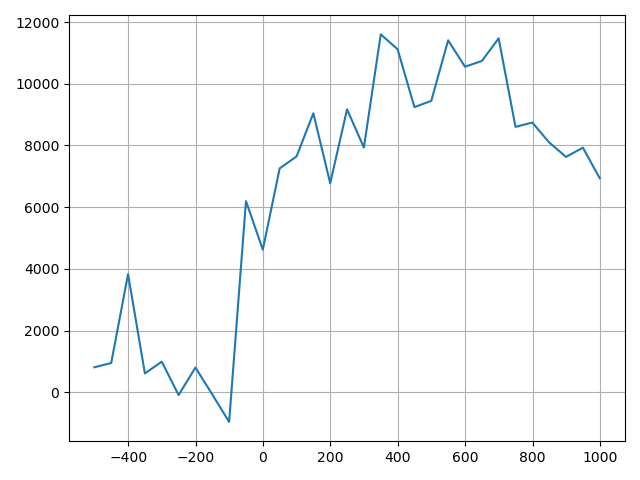

In [454]:
plt.figure()
plt.plot(Delay_fs, (all_files[:,62:67]).sum(axis = 1)+np.abs((all_files[:,67:73]).sum(axis = 1)))
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
Delay_mm = load_scan_readback('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_loop_1_2.json')

scan_name_load = 'Febpy_XES_timescan_loop_1_1'

##########################################################

#outdir = '/das/work/p18/p18442/Exported_data/'
fn = outdir + scan_name_load + "_export.h5" 
print (fn)
with h5py.File(fn, "r") as file2open:
    RIXS_pumped_roi1 = file2open['RIXS_pumped_roi1'][:]
    RIXS_unpumped_roi1 = file2open['RIXS_unpumped_roi1'][:]
    RIXS_transient_roi1 = file2open['RIXS_transient_roi1'][:]
    RIXS_pumped_roi3 = file2open['RIXS_pumped_roi3'][:]
    RIXS_unpumped_roi3 = file2open['RIXS_unpumped_roi3'][:]
    RIXS_transient_roi3 = file2open['RIXS_transient_roi3'][:]

In [117]:
images_pump_roi1_thr.shape

(1000, 80, 160)

<IPython.core.display.Javascript object>


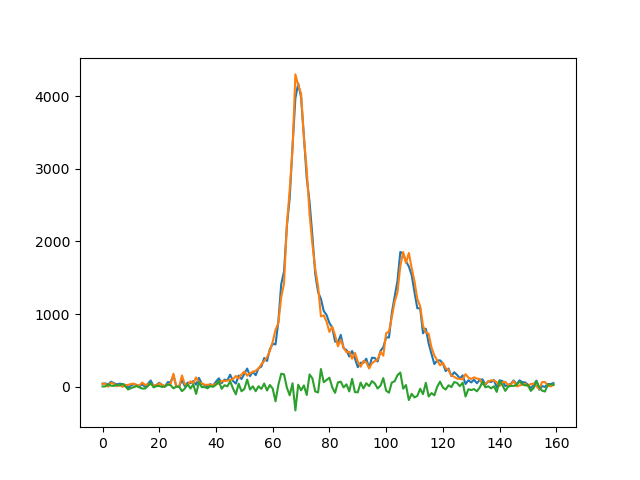

In [329]:

plt.figure()
plt.plot(RIXS_pumped_roi1[0])
plt.plot(RIXS_unpumped_roi1[0])
plt.plot(RIXS_transient_roi1[0])

plt.show()

<IPython.core.display.Javascript object>


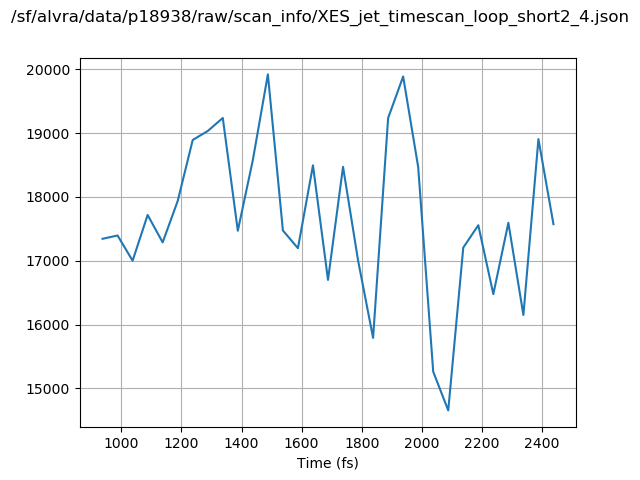

In [222]:
Delay_fs = (Delay_mm - 235.79686)*2/(3e8*1e3*1e-15)
plt.figure()
plt.suptitle(json_file)
plt.plot(Delay_fs, XAS_total_roi1)
plt.xlabel ('Time (fs)')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


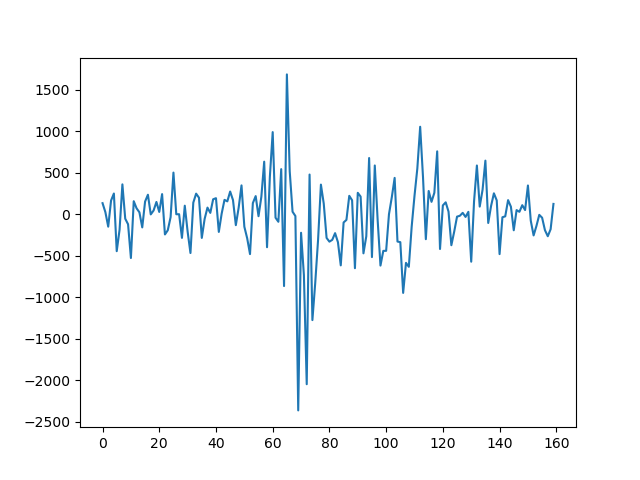

In [225]:
plt.figure()
plt.plot(RIXS_transient_roi1.sum(axis = 0))
plt.show()

In [224]:
RIXS_transient_roi1.sum(axis=0).shape

(160,)

In [289]:
json_file.split('/')[-1].split('.')[0]

'Febpy_XES_timescan_loop_1_1'

## Next cells for an scan, any channel (BSDATA & JF) 

In [2]:
fc = FileChooser('/sf/alvra/data/p18442/res/scan_info')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18442/res/scan_info', filename='', show_hidden='False')

In [ ]:
channel_list_pp = [channel_Events, channel_PIPS_fluo, 'JF02T09V02']
channel_list_all = channel_list_pp

roi1 = (5000, 5150, 220, 290) # Ru La ROIs
roi2 = (5000, 5150, 290, 360) 

roi3 = (6450, 6451, 220, 221)
roi4 = (6450, 6451, 220, 221)

threshold_low = 2.0

####################################################################################################3
clock = Clock()
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
xaxis = scan.readbacks

XAS_roi1 = []
XAS_roi1_on = []
#Error_XAS_roi1 = []
XAS_roi2 = []
XAS_roi2_on = []
#Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []
XAS_transient_roi1=[]
XES_transient_roi1 =[]
XAS_transient_roi2=[]
XES_transient_roi2 =[]

for i, step in enumerate(scan):
    check_files_and_data(step)
    clear_output(wait=True)
    filename = scan.files[i][0].split('/')[-1].split('.')[0]
    print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    
    resultsPP, results, _, _ = load_data_compact_laser_pump_JF(channel_list_pp, channel_list_all, step, roi1, roi2, roi3, roi4)

    Data_fluo_pump = resultsPP[channel_PIPS_fluo].pump
    Data_fluo_unpump = resultsPP[channel_PIPS_fluo].unpump
    images_pump_roi1 = resultsPP['JFroi1'].pump
    images_unpump_roi1 = resultsPP['JFroi1'].unpump
    images_pump_roi2 = resultsPP['JFroi2'].pump
    images_unpump_roi2 = resultsPP['JFroi2'].unpump
    #images_pump_roi3 = resultsPP['JFroi3'].pump
    #images_unpump_roi3 = resultsPP['JFroi3'].unpump
    #images_pump_roi4 = resultsPP['JFroi4'].pump
    #images_unpump_roi4 = resultsPP['JFroi4'].unpump
    
 #   Delay_mm_single = resultsPP[channel_delay_topas].pump[0]
    
    images_pump_roi1_thr = images_pump_roi1.copy()
    images_pump_roi1_thr[images_pump_roi1 < threshold_low] = 0
    #images_pump_roi1_thr[images_pump_roi1 > threshold_high] = 0
    images_unpump_roi1_thr = images_unpump_roi1.copy()
    images_unpump_roi1_thr[images_unpump_roi1 < threshold_low] = 0
    #images_unpump_roi1_thr[images_unpump_roi1 > threshold_high] = 0
    
    images_pump_roi2_thr = images_pump_roi2.copy()
    images_pump_roi2_thr[images_pump_roi2 < threshold_low] = 0
    #images_pump_roi2_thr[images_pump_roi2 > threshold_high] = 0
    images_unpump_roi2_thr = images_unpump_roi2.copy()
    images_unpump_roi2_thr[images_unpump_roi2 < threshold_low] = 0
    #images_unpump_roi2_thr[images_unpump_roi2 > threshold_high] = 0
    
    #images_pump_roi3_thr = images_pump_roi3.copy()
    #images_pump_roi3_thr[images_pump_roi3 < threshold_low] = 0
    #images_pump_roi3_thr[images_pump_roi3 > threshold_high] = 0
    #images_unpump_roi3_thr = images_unpump_roi3.copy()
    #images_unpump_roi3_thr[images_unpump_roi3 < threshold_low] = 0
    #images_unpump_roi3_thr[images_unpump_roi3 > threshold_high] = 0
    
    #images_pump_roi4_thr = images_pump_roi4.copy()
    #images_pump_roi4_thr[images_pump_roi4 < threshold_low] = 0
    #images_pump_roi4_thr[images_pump_roi4 > threshold_high] = 0
    #images_unpump_roi4_thr = images_unpump_roi4.copy()
    #images_unpump_roi4_thr[images_unpump_roi4 < threshold_low] = 0
    #images_unpump_roi4_thr[images_unpump_roi4 > threshold_high] = 0
    
    spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
    
    ######################### ROI 1 ##############################################
    
    XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum()))
    XAS_roi1_on.append(np.abs(spectrum_ON_roi1.sum()))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    XES_transient_roi1.append(np.abs(spectrum_ON_roi1 - spectrum_OFF_roi1))
 #   XES_1D.append(np.sum(XES_transient_roi1, axis = 1))
    
    XAS_transient_roi1.append(np.abs(np.sum(RIXS_transient_roi1)))
    
######################### ROI 2 ##############################################
    
    XAS_roi2.append(np.abs(spectrum_OFF_roi2.sum()))
    XAS_roi2_on.append(np.abs(spectrum_ON_roi2.sum()))
    RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
    Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
    RIXS_pumped_roi2.append(spectrum_ON_roi2)
    Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
    RIXS_transient_roi2.append(spectrum_ON_roi2 - spectrum_OFF_roi2)
    Error_transient_roi2.append(np.sqrt((np.sqrt(spectrum_ON_roi2))**2 + (np.sqrt(spectrum_OFF_roi2))**2))
    
    XES_transient_roi2.append(np.abs(spectrum_ON_roi2 - spectrum_OFF_roi2))
#    XES_1D.append(np.sum(XES_transient_roi2, axis = 1))
    
    XAS_transient_roi2.append(np.abs(np.sum(RIXS_transient_roi2)))
    clear_output(wait=True)
    
    print ("It took {} to process this file".format(clock.tick()))
    
Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
XAS_roi1_on = np.array(XAS_roi1_on)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)
XAS_transient_roi1=np.array(XAS_transient_roi1)
XES_transient_roi1=np.array(XES_transient_roi1)
#XES_1D=np.array(XES_1D)
XAS_roi2 = np.array(XAS_roi2)
XAS_roi2_on = np.array(XAS_roi2_on)
RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
Error_pumped_roi2 = np.array(Error_pumped_roi2)
RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
Error_transient_roi2 = np.array(Error_transient_roi2)
XAS_transient_roi2=np.array(XAS_transient_roi2)
XES_transient_roi2=np.array(XES_transient_roi2)
#XES_1D=np.array(XES_1D)
    
print ("\nJob done! It took", clock.tock(), "seconds to process all the files")

    
    

Step 4 of 21: Processing run_001497

--------------------------------------------------------------------------------

JF02T09V02               10000 / 19999 -> 50% loss ▇▇▇▇▇
SAR-CVME-TIFALL5:EvtSet  19999 / 19999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET 19999 / 19999 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 10000 / 19999 -> 50% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1


In [ ]:
plt.figure(figsize=(10,8))
plt.suptitle(fc.selected)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS unpumped roi2")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS pumped roi2")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi2")
plt.colorbar()



plt.show()

# New script in the next cell (single file)

In [ ]:
datalist = glob.glob(DIR + "*.JF02T09V02.h5")
datalist = sorted(datalist)
roi1 = (5000, 5200, 220, 290) # Ru ROIs
roi2 = (4600, 4800, 220, 290)
nshots = None

%mprun -f load_crop_JF_batches_on_off load_crop_JF_batches_on_off(datalist[0], roi1, roi2, 50, 25,\
                                                                  pedestal_file=pedestal_file, nshots=nshots)

In [ ]:
files = ["run_001612"]
detector = "JF02T09V02"

roi1 = (5000, 5200, 220, 290) # Ru ROIs
roi2 = (4600, 4800, 220, 290)
#roi1 = (100, 250, 140, 220)
#roi2 = (775, 925, 140, 220)

threshold_low = 2.0
threshold_high = 10

Timezero = 194.6   # position of Timezero on PP delay (in mm!)
######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
Energy_eV_single = 0
Delay_mm_single = 0
        
for f in files:
    JF_single_file = DIR + f + ".{}.h5".format(detector)
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
#    photon_range = (6, 7)

    nshots = None  # put this to None for ALL images
    #nshots = None
       
    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_batches_on_off(JF_single_file, roi1, roi2, 50, 25, pedestal_file=pedestal_file, \
                                nshots=nshots)
    
#   images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
#   load_crop_JF_data_on_off(JF_single_file, roi1, roi2, 50, 25, pedestal_file=pedestal_file, \
#                            nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(BS_single_file, channel_energy, 50)
    delay, pids = load_single_channel_pulseID(BS_single_file, channel_delay, 50)
    
    energy = [x for x in energy if (x > 0)]
    delay = [x for x in delay if (x > 0)]
    
    Energy_eV_single = np.mean(energy)
    Delay_mm_single = np.mean(delay)
    Delay_ps_single = (Delay_mm_single - Timezero)*2/(3e8*1e3*1e-12) # in ps, change to right t0 !
    
#    Izero_pump, Izero_unpump, energy_eV, pulseIDs = \
#    load_FEL_pp_pulseID(BS_single_file, channel_energy, 50, 25, 50)  
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2[images_ON_roi2 > threshold_high] = 0
#   images_ON_roi2 = convert_to_photon_num_range(images_ON_roi2)

    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
#   images_OFF_roi1 = convert_to_photon_num_range(images_OFF_roi1)

    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2[images_OFF_roi2 > threshold_high] = 0
#   images_OFF_roi2 = convert_to_photon_num_range(images_OFF_roi2)

    spectrum_ON_roi1  = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2  = images_ON_roi2.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2.sum(axis = 1).sum(axis = 0)
    
print ("Job done! It took {} seconds to process {} file".format(round((time.time() - start_time), 2),len(files)))

## Plot spectra of both ROIs together

In [ ]:
from textwrap import wrap
bin1_ = 1  # change the bin size if wanted, 1 is every pixel
bin2_ = 1  # change the bin size if wanted, 1 is every pixel

spectra_on1 = spectrum_ON_roi1.copy()
spectra_off1 = spectrum_OFF_roi1.copy()
spectra_on2 = spectrum_ON_roi2.copy()
spectra_off2 = spectrum_OFF_roi2.copy()

x_axis1 = np.arange(roi1[0], roi1[1])
x_axis2 = np.arange(roi2[0], roi2[1])

spectra_on_rebin1  = bin_sum(spectra_on1,  bin1_)
spectra_off_rebin1 = bin_sum(spectra_off1, bin1_)
x_axis_rebin1 = bin_mean(x_axis1, bin1_)
spectra_on_rebin2  = bin_sum(spectra_on2,  bin2_)
spectra_off_rebin2 = bin_sum(spectra_off2, bin2_)
x_axis_rebin2 = bin_mean(x_axis2, bin2_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)
spectra_on_err2  = np.sqrt(spectra_on_rebin2)
spectra_off_err2 = np.sqrt(spectra_off_rebin2)

low_err1= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err1= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
low_err2= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err2= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)

plt.figure(figsize=(10,5))
plt.suptitle(scan_name)

plt.subplot(221)

plt.gca().set_title("\n".join(wrap('ROI1: {} Energy = {} eV'.format(roi1, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI1: [], Delay = {} ps'.format(roi1, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(223)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin1, low_err1, high_err1, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.subplot(222)
plt.gca().set_title("\n".join(wrap('ROI2: {} Energy = {} eV'.format(roi2, np.round(Energy_eV_single, 2)),30)))
#plt.gca().set_title('ROI2: [], Delay = {} ps'.format(roi2, np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

plt.subplot(224)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.fill_between(x_axis_rebin2, low_err2, high_err2, color='lightblue')
plt.legend(loc="best")
plt.xlabel("JF pixel")
plt.grid()

plt.show()

## Or separately: ROI1

In [ ]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[0], roi1[1])

spectra_on_rebin1  = bin_sum(spectra_on,  bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)



#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.suptitle(scan_name + ' // ROI1: {}'.format(roi1))
plt.subplot(211)
plt.gca().set_title('Energy = {} eV'.format(np.round(Energy_eV_single, 2)))
#plt.gca().set_title('Delay = {} ps'.format(np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.xlabel("JF pixel")
plt.grid()


plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

## Or separately: ROI2

In [ ]:
bin_ = 1  # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi2.copy()
spectra_off = spectrum_OFF_roi2.copy()

x_axis = np.arange(roi2[0], roi2[1])

spectra_on_rebin2  = bin_sum(spectra_on,  bin_)
spectra_off_rebin2 = bin_sum(spectra_off, bin_)
x_axis_rebin2 = bin_mean(x_axis, bin_)

spectra_on_err2  = np.sqrt(spectra_on_rebin2)
spectra_off_err2 = np.sqrt(spectra_off_rebin2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.suptitle(scan_name + ' // ROI1: {}'.format(roi1))
plt.subplot(211)
plt.gca().set_title('Energy = {} eV'.format(np.round(Energy_eV_single, 2)))
#plt.gca().set_title('Delay = {} ps'.format(np.round(Delay_ps_single, 2)))
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
plt.grid()

#plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.xlabel("JF pixel")
plt.grid()

#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

# New script in the next cell (scans) 

In [ ]:
print (DIR_json + scan_name + scan_range + ".json")

In [ ]:
scan_name = "RuBpy_RIXS_1"          # you need to change this name, but run also cell #3 above to get scan_range
detector = "JF02T09V02"

roi1 = (5000, 5200, 220, 290)
roi2 = (4600, 4800, 220, 290) #Ru ROIs
#roi1 = (6450, 6550, 220, 300)
#roi2 = (5450, 5700, 220, 300)
threshold_low = 2.0
threshold_high = 10

######################################################################################

fname_scan = DIR_json + scan_name + scan_range + ".json"
scan_data = load_scan_data(fname_scan)


Energy_eV = []
Delay_mm = []
XAS_roi1 = []
XAS_roi1_on = []
#Error_XAS_roi1 = []
XAS_roi2 = []
XAS_roi2_on = []
#Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []
XAS_transient_roi1=[]
XES_transient_roi1 =[]
XAS_transient_roi2=[]
XES_transient_roi2 =[]

#XES_1D = []

clock = Clock()
num_scan_files = len(scan_data)
print("\nProcessing", num_scan_files, "total files")

for i, (bs, fn) in enumerate(scan_data):
#for i in range(0,4):
    print("\n File {} out of {}: Processing {}".format(i+1, num_scan_files, fn.split('/')[-2:]))
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    
    nshots = None  # put this to None for ALL images
    #nshots = None
    
    
    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_batches_on_off_2rois(fn, roi1, roi2, 50, 25, pedestal_file=pedestal_file, nshots=nshots)
    
#   images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
#   load_crop_JF_data_on_off(fn, roi1, roi2, 50, 25, pedestal_file=pedestal_file, nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    delay, pids = load_single_channel_pulseID(bs, channel_delay, 50)
    delay = [x for x in delay if (x > 0)]
    Delay_mm.append(np.mean(delay))
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
    
    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
    
    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2_thr[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2_thr[images_ON_roi2 > threshold_high] = 0
    
    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2_thr[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2_thr[images_OFF_roi2 > threshold_high] = 0
    
    spectrum_ON_roi1 = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_ON_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2_thr.sum(axis = 1).sum(axis = 0)

######################### ROI 1 ##############################################
    
    XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum()))
    XAS_roi1_on.append(np.abs(spectrum_ON_roi1.sum()))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    XES_transient_roi1.append(np.abs(spectrum_ON_roi1 - spectrum_OFF_roi1))
 #   XES_1D.append(np.sum(XES_transient_roi1, axis = 1))
    
    XAS_transient_roi1.append(np.abs(np.sum(RIXS_transient_roi1)))
    
######################### ROI 2 ##############################################
    
    XAS_roi2.append(np.abs(spectrum_OFF_roi2.sum()))
    XAS_roi2_on.append(np.abs(spectrum_ON_roi2.sum()))
    RIXS_unpumped_roi2.append(spectrum_OFF_roi2)
    Error_unpumped_roi2.append(np.sqrt(spectrum_OFF_roi2))
    RIXS_pumped_roi2.append(spectrum_ON_roi2)
    Error_pumped_roi2.append(np.sqrt(spectrum_ON_roi2))
    RIXS_transient_roi2.append(spectrum_ON_roi2 - spectrum_OFF_roi2)
    Error_transient_roi2.append(np.sqrt((np.sqrt(spectrum_ON_roi2))**2 + (np.sqrt(spectrum_OFF_roi2))**2))
    
    XES_transient_roi2.append(np.abs(spectrum_ON_roi2 - spectrum_OFF_roi2))
#    XES_1D.append(np.sum(XES_transient_roi2, axis = 1))
    
    XAS_transient_roi2.append(np.abs(np.sum(RIXS_transient_roi2)))
    clear_output(wait=True)
    
    print ("It took {} to process file {}".format(clock.tick(), fn.split('/')[-1]))

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
XAS_roi1_on = np.array(XAS_roi1_on)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)
XAS_transient_roi1=np.array(XAS_transient_roi1)
XES_transient_roi1=np.array(XES_transient_roi1)
#XES_1D=np.array(XES_1D)
XAS_roi2 = np.array(XAS_roi2)
XAS_roi2_on = np.array(XAS_roi2_on)
RIXS_unpumped_roi2 = np.array(RIXS_unpumped_roi2)
Error_unpumped_roi2 = np.array(Error_unpumped_roi2)
RIXS_pumped_roi2 = np.array(RIXS_pumped_roi2)
Error_pumped_roi2 = np.array(Error_pumped_roi2)
RIXS_transient_roi2 = np.array(RIXS_transient_roi2)
Error_transient_roi2 = np.array(Error_transient_roi2)
XAS_transient_roi2=np.array(XAS_transient_roi2)
XES_transient_roi2=np.array(XES_transient_roi2)
#XES_1D=np.array(XES_1D)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")



In [ ]:
outdir = '/das/work/p18/p18442/Exported_data/'
filename_h5 = outdir + scan_name + "_export.h5" 
with h5py.File(filename_h5, "w") as file2write:
    file2write.create_dataset("energy_eV", data = Energy_eV)
    file2write.create_dataset("roi1", data = roi1)
    file2write.create_dataset("pump_roi1", data = RIXS_pumped_roi1)
    file2write.create_dataset("unpump_roi1", data = RIXS_unpumped_roi1)
    file2write.create_dataset("transient_roi1", data = RIXS_transient_roi1)
    file2write.create_dataset("roi2", data = roi2)
    file2write.create_dataset("pump_roi2", data = RIXS_pumped_roi2)
    file2write.create_dataset("unpump_roi2", data = RIXS_unpumped_roi2)
    file2write.create_dataset("transient_roi2", data = RIXS_transient_roi2)

print(filename_h5)

In [ ]:
scan_name_load = 'RuBpy_RIXS_6'

##########################################################

outdir = '/das/work/p18/p18442/Exported_data/'
fn = outdir + scan_name_load + "_export.h5" 
print (fn)
with h5py.File(fn, "r") as file2open:
    Energy_eV = file2open['energy_eV'][:]
    roi1 = file2open['roi1'][:]
    RIXS_pumped_roi1 = file2open['pump_roi1'][:]
    RIXS_unpumped_roi1 = file2open['unpump_roi1'][:]
    RIXS_transient_roi1 = file2open['transient_roi1'][:]
    roi2 = file2open['roi2'][:]
    RIXS_pumped_roi2 = file2open['pump_roi2'][:]
    RIXS_unpumped_roi2 = file2open['unpump_roi2'][:]
    RIXS_transient_roi2 = file2open['transient_roi2'][:]

### For no pump probe data:

In [ ]:
RIXS_total = RIXS_unpumped_roi1 + RIXS_pumped_roi1

plt.figure(figsize=(8,4))
plt.imshow(RIXS_total, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")

plt.title(scan_name_load)
plt.colorbar()
plt.show()


### For pump probe data (ROI1 and ROI2 together):

In [ ]:
plt.figure(figsize=(10,8))
plt.suptitle(scan_name_load)
plt.subplots_adjust(hspace=0.5)

plt.subplot(321)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()

plt.subplot(322)
plt.imshow(RIXS_unpumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS unpumped roi2")
plt.colorbar()

plt.subplot(323)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS pumped roi1")
plt.colorbar()

plt.subplot(324)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS pumped roi2")
plt.colorbar()

plt.subplot(325)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()

plt.subplot(326)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi2")
plt.colorbar()



plt.show()

### Only ROI1

In [ ]:
plt.figure(figsize=(5,9))
plt.suptitle(scan_name_load)
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi1")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped roi1")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi1")
plt.colorbar()
plt.show()

### Only ROI2

In [ ]:
plt.figure(figsize=(5,9))
plt.suptitle(scan_name_load)
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped roi2")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped roi2")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi2, aspect = 'auto', cmap = "bwr", origin ="lower", \
           extent=[roi2[0], roi2[1], Energy_eV[0], Energy_eV[-1]], vmin=-250, vmax=250)
plt.title("RIXS transient roi2")
plt.colorbar()
plt.show()

## XAS plots in PFY

### ROI1

In [ ]:
XAS_pump_roi1 =  np.sum(RIXS_pumped_roi1, axis=1)
XAS_unpump_roi1 = np.sum(RIXS_unpumped_roi1, axis=1)
XAS_pumpprobe_roi1 = XAS_pump_roi1 - XAS_unpump_roi1

plt.figure(figsize=(10,5))
plt.suptitle(scan_name_load + '    XAS, roi1')
plt.subplot(121)
plt.plot(Energy_eV,XAS_pump_roi1, label="laser on", marker='.')
plt.plot(Energy_eV,XAS_unpump_roi1, label="laser off", marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.ylabel("Counts")

plt.subplot(122)
plt.plot(Energy_eV,XAS_pumpprobe_roi1, label="pump probe",color='green', marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.show()

### ROI2

In [ ]:
XAS_pump_roi2 =  np.sum(RIXS_pumped_roi2, axis=1)
XAS_unpump_roi2 = np.sum(RIXS_unpumped_roi2, axis=1)
XAS_pumpprobe_roi2 = XAS_pump_roi2 - XAS_unpump_roi2

plt.figure(figsize=(10,5))
plt.suptitle(scan_name_load + '    XAS, roi2')
plt.subplot(121)
plt.plot(Energy_eV,XAS_pump_roi2, label="laser on", marker='.')
plt.plot(Energy_eV,XAS_unpump_roi2, label="laser off", marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.ylabel("Counts")

plt.subplot(122)
plt.plot(Energy_eV,XAS_pumpprobe_roi2, label="pump probe",color='green', marker='.')
plt.legend(loc='best')
plt.xlabel("Incident energy (eV)")
plt.grid()
plt.show()

In [ ]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure(figsize=(8,4))
plt.plot(Delay_ps, XES_transient_roi1.sum(axis = 1), marker ='.')
plt.xlabel("delay (ps)")
plt.ylabel("Incident energy (eV)")

plt.title(scan_name)
plt.show()


In [ ]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure()
#plt.plot(Energy_eV,RIXS_transient_roi1, label="", marker='.')
plt.plot(Delay_ps,XES_1D, label="", marker='.')
plt.xlabel("Delay (ps)")
plt.ylabel("Counts")
plt.show

In [ ]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_ps[0], Delay_ps[-1]])
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_ps[0], Delay_ps[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi1[0], roi1[1], Delay_ps[0], Delay_ps[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.abs(RIXS_transient_roi1))

In [ ]:
plt.figure()
#plt.plot(Energy_eV,RIXS_transient_roi1, label="", marker='.')
plt.plot(Energy_eV,XAS_roi1_on-XAS_roi1, label="", marker='.')
plt.xlabel("Incident energy (eV)")
plt.ylabel("Counts")
plt.show

plt.figure()
plt.plot(x_axis,RIXS_transient_roi1.sum(axis=0), label="", marker='.')
plt.xlabel("Pixels")
plt.ylabel("Counts")
plt.show

plt.figure()
plt.plot(Delay_ps,np.abs(RIXS_transient_roi1).sum(axis=1), label="", marker='.')
plt.xlabel("Delay ps")
plt.ylabel("Counts")
plt.show

In [ ]:
Timezero = 194.6   # position of Timezero on PP delay (in mm!)
Delay_ps = (Delay_mm - Timezero)*2/(3e8*1e3*1e-12) # change to right t0 !

plt.figure()
#plt.plot(Energy_eV,RIXS_transient_roi1, label="", marker='.')
plt.plot(Delay_ps,XAS_roi1_on-XAS_roi1, label="", marker='.')
plt.xlabel("Delay (ps)")
plt.ylabel("Counts")
plt.show

In [ ]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_mm[0], Energy_eV[-1]])
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Delay_mm[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi1[0], roi1[1], Delay_mm[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

In [ ]:
savedir = '/das/work/p18/p18387/exported_data/'
filename_txt = savedir + "run001710_Ka.txt" 
output_matrix =[]
output_matrix = np.array(x_axis)
output_matrix = np.vstack((output_matrix, np.array(spectrum_ON_roi1)))
output_matrix = np.vstack((output_matrix, np.array(spectrum_OFF_roi1)))
#output_matrix = np.array()
#output_matrix = np.vstack((output_matrix, np.array(spectrum_ON_roi2)))
#output_matrix = np.vstack((output_matrix, np.array(spectrum_OFF_roi2)))

np.savetxt(filename_txt, np.transpose(output_matrix))

In [ ]:
def edge_removal(module_edge, roi_removal, array):
    index_edge = module_edge - roi_removal[0]
    array_input = array.copy()
    print (array[index_edge-1:index_edge+3])
    array[index_edge] = array[index_edge-1]/2
    array[index_edge-1] = array[index_edge-1]/2

    array[index_edge+1] = array[index_edge+2]/2
    array[index_edge+2] = array[index_edge+2]/2 
    print (array[index_edge-1:index_edge+3])
    return array, array_input

In [ ]:
spectrum_ON_roi1, spectrum_ON_roi1_orig = edge_removal(6472, roi1, spectrum_ON_roi1) 
spectrum_OFF_roi1, spectrum_OFF_roi1_orig = edge_removal(6472, roi1, spectrum_OFF_roi1) 

<IPython.core.display.Javascript object>


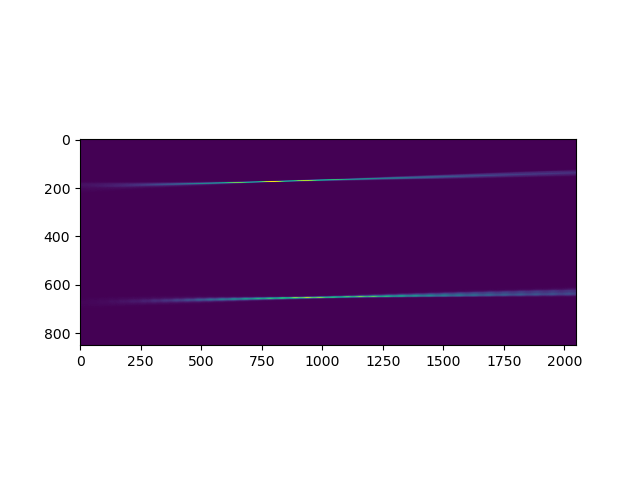

In [7]:
with SFDataFiles("/sf/alvra/data/p18938/raw/scan_data/SiN_timing_NOPA_shortX_loop3_000/run_014886.CAMERAS.h5") as sfd:
    ch = sfd['SARES11-SPEC125-M2:FPICTURE']
    img = ch.data[0]

plt.imshow(img)